# Comparons les différentes méthodes de régressions symboliques

## Pour le probleme 1


### Import des données, des librairies et def des fonctions

In [30]:
import os 
os.chdir('/vol/usersmeca2/challier')
os.getcwd()

'/vol/usersmeca2/challier'

In [31]:
import UTILS.TOOLS.fct_readsunfluidhdata as rsd # import the reading routines as rsd
import matplotlib.pyplot as plt
import numpy as np
from UTILS.TOOLS.tools_hdf5_m import *
import h5py
from pathlib import Path
from UTILS.TOOLS.tools_subplot import *
import matplotlib.colors as mcolors
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
#from pysindy import FiniteDifference
import pysindy as ps
import kan
import torch
import time
from torch import autograd
from tqdm import tqdm

plt.rcParams.update({ # +6partout, +4 titres, -2 ticks&legend, +2 axeslabel, +4partout
    'font.size': 24,            # Police globale plus grande
    'axes.titlesize': 30,       # Titres d'axes bien visibles
    'axes.labelsize': 26,       # Labels d'axes
    'xtick.labelsize': 20,      # Taille des ticks
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif'],
    'mathtext.fontset': 'dejavuserif',
    "text.usetex": False,
    # "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    # 'mathtext.fontset': 'cm',
    'lines.linewidth': 2,
    'axes.linewidth': 1.2,
    'axes.edgecolor': 'black',
    'axes.grid': False,
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
    'legend.frameon': True,
    'figure.dpi': 150,           # Pour une meilleure résolution
    'savefig.dpi': 300,          # Pour les figures exportées
})

# recupère les coupes
def recup_slices(n_run, slicedir, sliceid, idtime, nlaps, champs): 
    datafilename = f"/workdir/challier/SLICE_H5_RUN{n_run}" + f'/slice_{sliceid:02d}_' + f'{slicedir}_' + f'{idtime:07d}' + '.h5'
    #keys_file=Read_H5_Spav(datafilename,keyreading=True)
    xxh,yyh=Read_H5_Spav(datafilename,gridreading=True)


    slices = np.zeros([len(xxh), len(yyh), len(nlaps), len(champs)])
    tt = np.zeros(len(nlaps))


    for n in range(len(nlaps)):  
        idtime = nlaps[n]
        datafilename = f"/workdir/challier/SLICE_H5_RUN{n_run}" + f'/slice_{sliceid:02d}_' + f'{slicedir}_' + f'{idtime:07d}' + '.h5'
        

        for i, c in enumerate(champs) : 
            time,fields=Read_H5_Spav(datafilename, c)
            slices[:,:, n, i] = fields

        tt[n] = time


    return slices, xxh, yyh, tt

# normalisation
def normalize(X):
    if type(X)==np.ndarray:
        X_mean = np.mean(X, axis=(0, 1))
        X_std = np.std(X, axis=(0, 1))
    elif type(X)==torch.Tensor:
        X_mean = torch.mean(X, axis=[0, 1])
        X_std = torch.std(X, axis=[0, 1])
    else:
        raise ValueError('Type not supported')
    X_normed = (X - X_mean )/ X_std
    return X_normed, X_mean, X_std

def unormalize(X_normed, X_mean, X_std):
    X_unormed = X_normed * X_std + X_mean
    return X_unormed

def reshp(X):
    return X.reshape(X.shape[0]*X.shape[1], X.shape[2])

# device cpu pour grappe
device = 'cpu'

Import des données et découpe de la slice.

In [32]:
# run 1

########## Parametres des slices ##########
n_run = 1
slicedir = 2
sliceid = 7
idtime = 5886

## temps run1 : 5886 
## temps run2 : 6353
## temps run3 : 6820 (ntime=466)
## temps run4 : 7286

ntime = 467 # number of instants (nombre)
nfin = int(idtime+ntime-1) # issue of instants (numero fin)
nech=1

nlaps = np.arange (idtime,nfin+1,nech)
champs = ['U','W','T']
##########################################

## recupere les slices

slices_r1, xxh, zzh, tt_r1 = recup_slices(n_run, slicedir, 
                            sliceid, idtime, nlaps, champs)

### coupe la slice
# - 320 : prend le x au centre 
# - [:125] : zoom sur le z pour avoir que les 0.1 prems
# - [293:393] : prend un bout de temps -> 293.5 to 295.5
# - [268:368] : prend un bout de temps -> 293 to 295
# - [121:368] : prend un bout de temps -> 290.0 to 295
# - garde tous les champs

X = slices_r1[320,:125,194:368,:].astype(np.float32)
t = tt_r1[194:368].astype(np.float32)
z = zzh[:125].astype(np.float32)
num_pb = 13 # 1 pour [293.5, 295.5] et 12 pour [293.0, 295.0]
            # 13 pour 291.5-295.0 -> 194:368
############

cond_lim = True 
if cond_lim :
    # ajout des cond limites en z=0

    a = np.zeros((1, len(t), 2))
    b = np.ones((1, len(t), 1))
    A = np.concatenate((a, b), axis=2)

    X= np.concatenate((A, X), axis=0)
    z= np.concatenate((np.zeros(1), z))

    # il faudrait que j'interpole pour les z entre z=0 et z[0] ?
# X = np.transpose(X, axes=(1,0,2))
X.shape # dimension (z, t, champs)



(126, 174, 3)

In [34]:
t.shape

(174,)

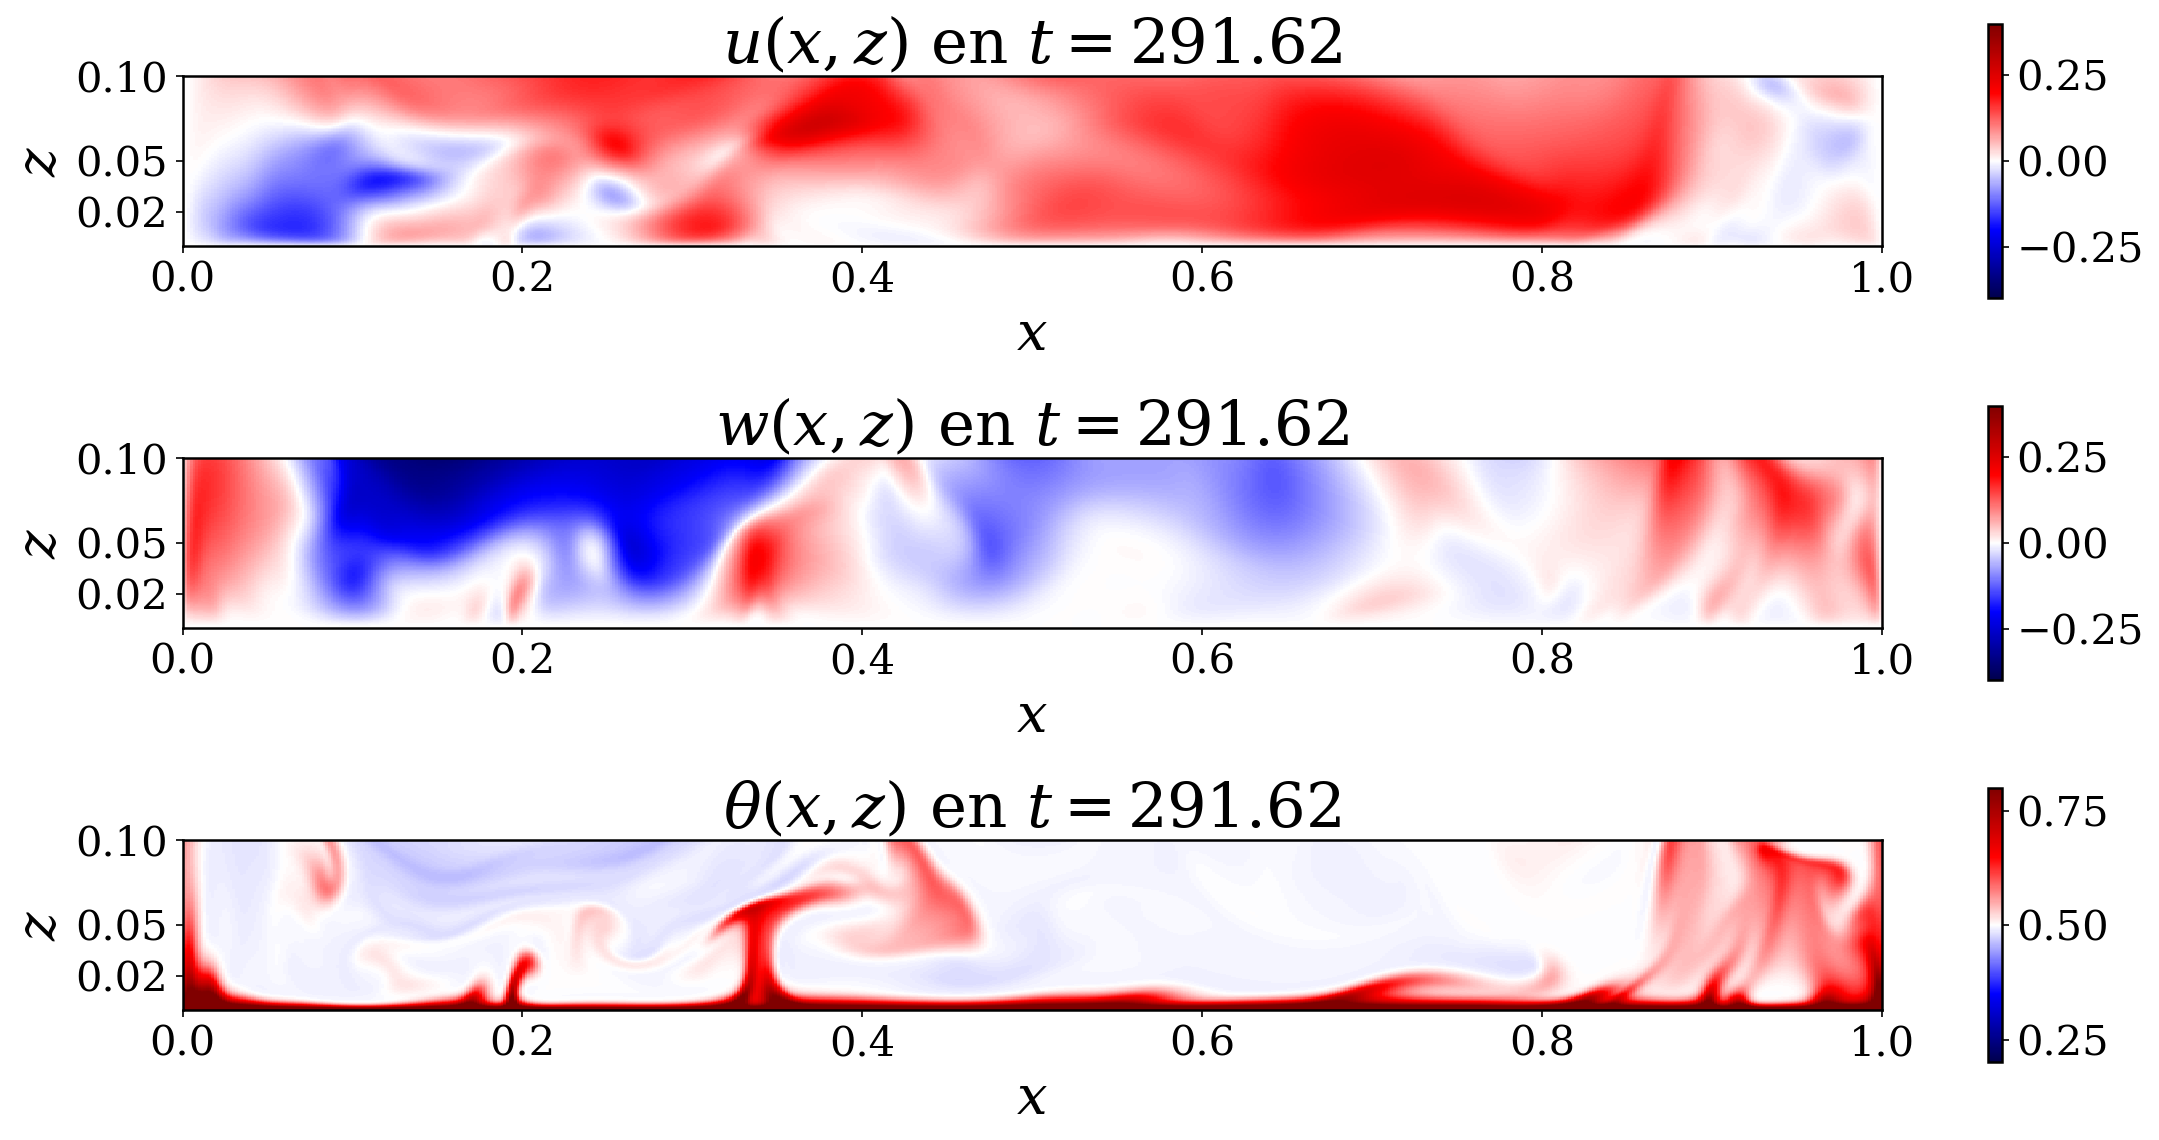

In [7]:
slices_r1.shape


fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,3)
ax3 = plt.subplot(3, 1, 2)

norm = mcolors.TwoSlopeNorm(vmin=-.4, vcenter=0.0, vmax=.4)
im1 = ax1.pcolor(xxh[:], zzh[:125], slices_r1[:,:125,200,0].T, cmap='seismic', norm=norm)
ax1.axis('image')
ax1.set_ylabel('$z$')
ax1.set_yticks([ 0.02, 0.05, 0.10])
ax1.set_xlabel('$x$')
ax1.set_title(r'$u(x,z)$'+f' en $t={tt_r1[200]:.2f}$')

plt.colorbar(im1, ax=ax1)

im3 = ax3.pcolor(xxh[:], zzh[:125], slices_r1[:,:125,200,1].T, cmap='seismic', norm=norm)
ax3.axis('image')
ax3.set_ylabel('$z$')
ax3.set_yticks([ 0.02, 0.05, 0.10])
ax3.set_xlabel('$x$')
ax3.set_title(r'$w(x,z)$'+f' en $t={tt_r1[200]:.2f}$')

plt.colorbar(im3, ax=ax3)

norm = mcolors.TwoSlopeNorm(vmin=0.2, vcenter=0.5, vmax=0.8)
im2 = ax2.pcolor(xxh[:], zzh[:125], slices_r1[:,:125,200,2].T, cmap='seismic', norm=norm)
#ax2.hlines(0.002205592513489272, 0, 1, color='k', linestyle='--')
plt.colorbar(im2, ax=ax2)
ax2.axis('image')
ax2.set_ylabel('$z$')
ax2.set_xlabel('$x$')
ax2.set_yticks([ 0.02, 0.05, 0.10])
ax2.set_title(r'$\theta(x,z)$'+f' en $t={tt_r1[200]:.2f}$')

fig.tight_layout()


plt.savefig(f'FIGURES/instant_aproche_paroi.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.savefig(f'FIGURES/instant_aproche_paroi.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [8]:
0.002205592513489272 * 4.38**(-1/2)

0.0010538728679576747

### Traitement des données   
- calcul des dérivées temporelles $t$ et spatiales en $z$ avec les différences finies
- création des entrées et des sorties
- normalisaton
- split train/test

In [35]:
# créer notre label y : les dérivées temporelles
y = np.gradient(X[:,:,[0,2]], t, axis=1, edge_order=2)

# calcule les derivées spatiales : pour les KANs, SINDy les calculs directements avec la librairie de fonction pour les PDEs
Xz = np.gradient(X, z, axis=0, edge_order=2) 
Xzz = np.gradient(Xz, z, axis=0, edge_order=2) 

# sort le maillage pour les KANs et la librairie WeakPDE # ptetre pas utile ? nan pas utile
TIME, Z = np.meshgrid(t, z)
ZT = np.concatenate(( Z.reshape(len(z), len(t), 1), TIME.reshape(len(z), len(t), 1)), axis=2) 

# et créer la matrice d'entrée pour les KANs et la convertit en tenseur plus tard
X_kan = np.concatenate((X, Xz, Xzz), axis=2)
X_sindy = X
y_kan = y
y_sindy = y

# normalisation des données 
normalisation = True
if normalisation : # pour les KANs, + SINDy aussi //SINDy normalise directement dans l'entraînement//
    X_kan, mean_X_kan, std_X_kan = normalize(X_kan)
    #y_kan, mean_y_kan, std_y_kan = normalize(y_kan)
    #X_sindy, mean_X_sindy, std_X_sindy = normalize(X_sindy) ## X et y reste sans normalisation => utile pour les visualisations
    #y_sindy, mean_y_sindy, std_y_sindy = normalize(y_sindy)

# split train/test 0.70/0.30%
tscv = TimeSeriesSplit(n_splits=2, test_size=int(t.size*0.3))
all_splits = list(tscv.split(t))
train_id, test_id = all_splits[1]   # prend train 0-79 et test 80-99

# split KANs dans un dictionnaire
# on ne peut pas utiliser le create_datasets_from_data de kan 
# car il y a un random.choice qui n'est pas compatible pour les TimesSeries
nb_features = X_kan.shape[2]
data_kan = {} # on reshape directement les données // ptetre fonctionne sans reshape ?? NON forcément (nb_obs, nb_features)
data_kan['train_input'] = torch.tensor(X_kan[:,train_id,:].reshape(len(z)*len(train_id), nb_features), dtype=torch.float32, device=device)
data_kan['test_input'] = torch.tensor(X_kan[:,test_id,:].reshape(len(z)*len(test_id), nb_features), dtype=torch.float32, device=device)
data_kan['train_label'] = torch.tensor(y_kan[:,train_id,:].reshape(len(z)*len(train_id), 2), dtype=torch.float32, device=device)
data_kan['test_label'] = torch.tensor(y_kan[:,test_id,:].reshape(len(z)*len(test_id), 2), dtype=torch.float32, device=device)

# split SINDy
X_train = X_sindy[:,train_id, :]
X_test = X_sindy[:,test_id, :]
y_train = y_sindy[:,train_id, :]
y_test = y_sindy[:,test_id, :]
t_train, t_test = t[train_id], t[test_id]  



In [37]:
t_test.shape

(52,)

## Définition et entraînement des modèles 

Maintenant que les données sont préparées, nous pouvons définir et entraîner les modèles.
Il faut créer les librairies de fonctions pour les modèles SINDy et WeakSINDy.
Définir les optimiseurs et leurs paramètres.

Les modèles ont les mêmes données d'entrée. Cependant, on ne leur donne pas de la même manière. SINDy construit une librairie de fonctions avec les dérivées spatiales en $z$ et prends des données d'entrée de dimension $(125, 100, 3)$ avec nos trois champs $[u, w, T]$. Alors que pour les KANs il faut applatir les données d'entrée, on ajoute le maillage de la fonction `np.meshgrid(t, z)` pour que le modèles puisse prendre en compte la struction spatio-temporelle des données. De plus, il faut ajouter les dérivées spatiales en $z$ pour que le modèle ait autant d'information que SINDy. On se retrouve donc avec une matrice d'entrée de dimension $(125 \times 100, 11)$.

### Les hyperparamètres 

Pour le modèle SINDy :
- library_functions : librairie de fonctions
- derivative order : ordre de dérivée
- include_bias : inclure un terme de biais
- include_interaction : autoriser les interactions entre les fonctions
- K : nombre de sous-domaines pour la formulation faible des PDEs

Pour le modèle KAN : 
- width : profondeur du réseau et nombre de neurones
- grid : nombre d'intervalles pour les splines
- k : ordre des polynômes

Pour l'optimisation : 
- optimizer : optimiseur de la fonction de coût
- threshold : seuil de coût

### PDE-SINDy

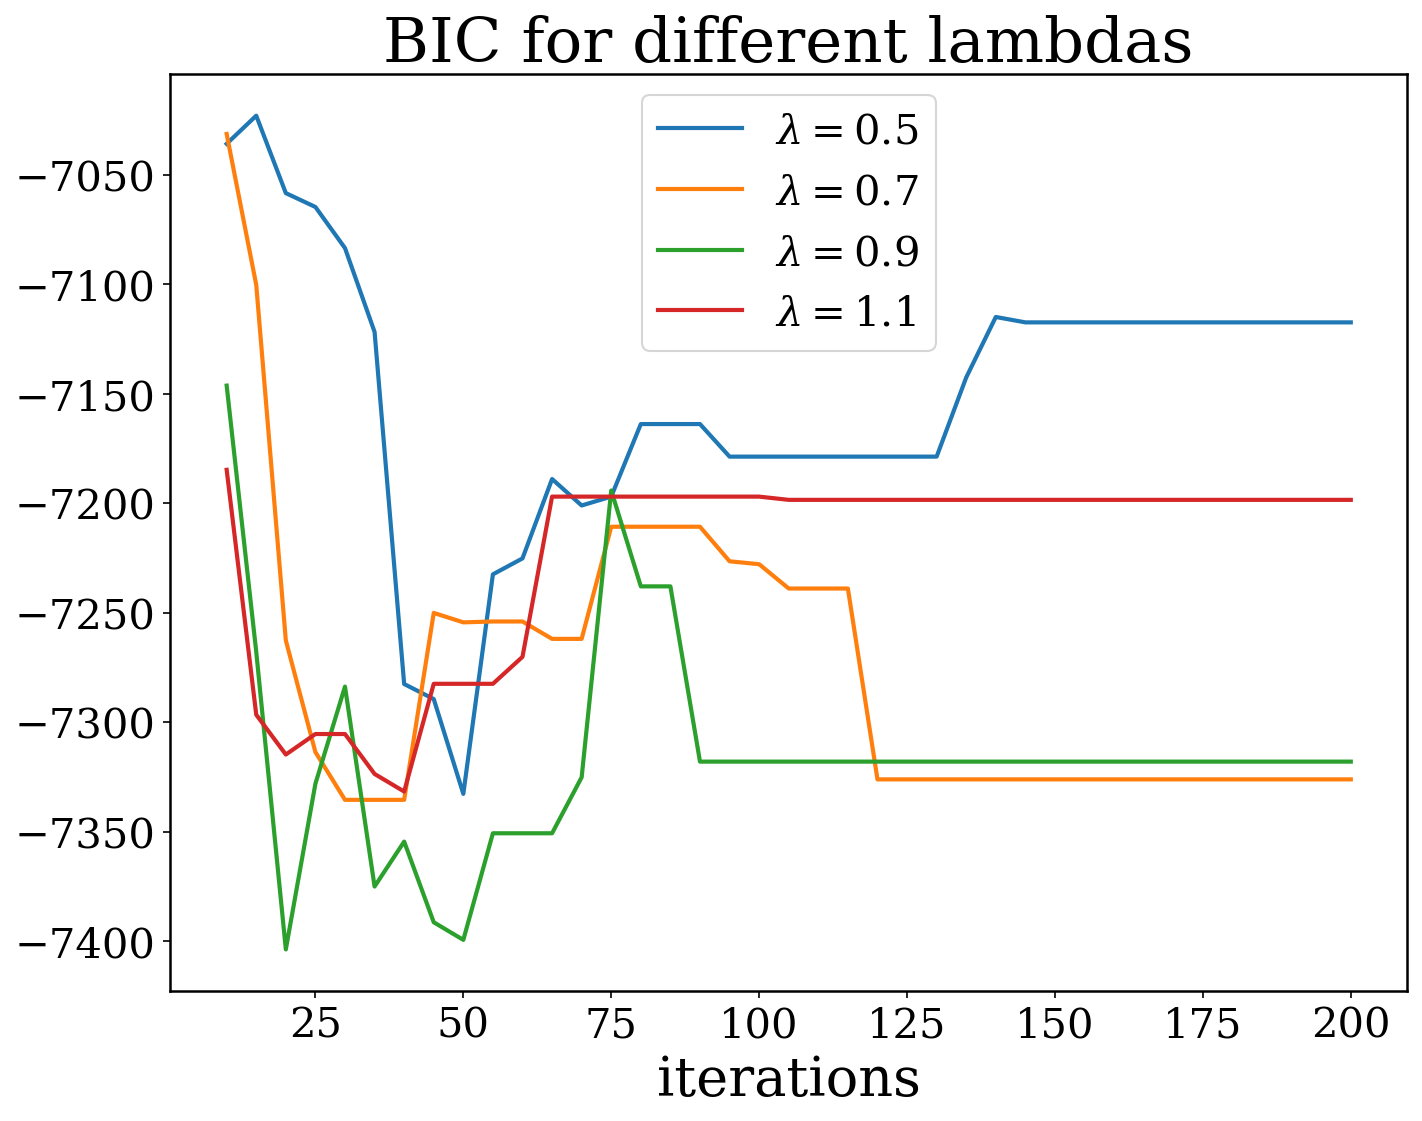

In [11]:
# choix de lambda
lamb_list = [0.5, 0.7, 0.9, 1.1]
nu_list = [0.5]
np.random.seed(1501)

plt.figure(figsize=(10, 8))
ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

for lamb in lamb_list : 
    for nu in nu_list : 
        # SINDy avec PDELibrary
        # création des librairies de fonctions

        library_functions = [lambda x: x]
        library_function_names = [lambda x: x]

        # pour SINDy 
        pde_lib = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                derivative_order=2, 
                                spatial_grid=z, # grille spatiale (z)
                                include_bias=True,
                                include_interaction=True,
                                is_uniform=False,
                                )

        ### Pour SR3
        ## Pour STLSQ on a juste a modif opt_sindy et les titres

        MAE_train, MAE_test = [], []
        R2_train, R2_test = [], []
        MSE_train, MSE_test = [], []
        MAPE_train, MAPE_test = [], []
        compl = []
        n_iters = 200

        opt_sindy = ps.SR3(threshold=lamb, thresholder='l1', normalize_columns=True, max_iter=n_iters, verbose=False, tol=1e-5, nu=nu)
        # opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
        model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])

        iters = range(10, n_iters+1, 5)
        for i in iters:
            # opt_sindy = ps.SR3(threshold=2, thresholder='l1', normalize_columns=True, max_iter=i, verbose=False, tol=1e-5, nu=1)
            # # opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
            # model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])
            model_sindy.optimizer.max_iter = i
            model_sindy.fit(X_train, x_dot=y_train, quiet=True)

            # metric train/test
            coef = model_sindy.coefficients()
            train_transf = model_sindy.feature_library.fit_transform(X_train)
            train_pred = train_transf @ coef.T
            test_transf = model_sindy.feature_library.fit_transform(X_test)
            test_pred = test_transf @ coef.T
            MAE_train.append(np.mean(np.abs(train_pred-y_train)))
            MAE_test.append(np.mean(np.abs(test_pred-y_test)))
            R2_train.append(1 - np.mean((train_pred-y_train)**2) / np.mean((y_train - y_train.mean(axis=(0, 1)))**2)  )
            R2_test.append(1 - np.mean((test_pred-y_test)**2) / np.mean((y_test - y_test.mean(axis=(0, 1)))**2)  )
            MSE_train.append(np.mean((train_pred-y_train)**2))
            MSE_test.append(np.mean((test_pred-y_test)**2))
            # MAPE_train.append(model_sindy.score(X_train, t=dt, metric=mean_absolute_percentage_error))
            # MAPE_test.append(model_sindy.score(X_test, t=dt, metric=mean_absolute_percentage_error))
            compl.append(model_sindy.complexity)

        nb_coeff = model_sindy.coefficients().shape
        n_train = len(t_train) * len(z)
        n_test = len(t_test)* len(z)
        AIC_test = n_test * np.log(MSE_test) + 2* np.array(compl)
        AIC_train = n_train * np.log(MSE_train) + 2* np.array(compl)
        BIC_test = n_test * np.log(MSE_test) + np.log(n_test)* np.array(compl)
        BIC_train = n_train * np.log(MSE_train) + np.log(n_train)* np.array(compl)

        # print(r"Modèle SINDy-PDE avec SR3:")
        # print("     Nombre de coefficients d'apprentissage :", nb_coeff)
        # print("     Complexité du modèle :", compl[-1])
        # print("     R2 score | training : ", R2_train[-1], "| testing : ", R2_test[-1]) # r2 
        # print("     MSE score | training : ", MSE_train[-1], "| testing : ", MSE_test[-1]) # r2 
        # print("     MAE score | training : ", MAE_train[-1], "| testing : ", MAE_test[-1]) # mse
        # print("     BIC : ", BIC_train[-1], "| AIC : ", AIC_train[-1])
        # print('\n\n')
        # model_sindy.print()

        ax1.plot(iters, BIC_test, label=r'$\lambda=$'+f'{lamb}')
        #ax2.plot(iters, R2_test)




ax1.legend()
plt.title('BIC for different lambdas')
ax1.set_xlabel('iterations')
plt.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_bic_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_bic_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()

In [38]:
# SINDy avec PDELibrary
# création des librairies de fonctions
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

# pour SINDy 
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, 
                        spatial_grid=z, # grille spatiale (z)
                        include_bias=True,
                        include_interaction=True,
                        is_uniform=False,
                        )

### Pour SR3
## Pour STLSQ on a juste a modif opt_sindy et les titres

MAE_train, MAE_test = [], []
R2_train, R2_test = [], []
MSE_train, MSE_test = [], []
MAPE_train, MAPE_test = [], []
compl = []
n_iters = 50

opt_sindy = ps.SR3(threshold=.9, thresholder='l1', normalize_columns=True, max_iter=n_iters, verbose=False, tol=1e-5, nu=.5)
# opt_sindy = ps.STLSQ(threshold=30, alpha=1e-5, normalize_columns=True, verbose=False, max_iter=n_iters)
model_sindy = ps.SINDy(feature_library=pde_lib, optimizer=opt_sindy, feature_names=['u', 'w', 'T'])
sindy_iters_complet = range(1, n_iters+1)
sindy_iters = range(10, n_iters+1, 10)
for i in sindy_iters:
    model_sindy.optimizer.max_iter = i
    model_sindy.fit(X_train, x_dot=y_train, quiet=True)

    # metric train/test
    coef = model_sindy.coefficients()
    train_transf = model_sindy.feature_library.fit_transform(X_train)
    train_pred = train_transf @ coef.T
    test_transf = model_sindy.feature_library.fit_transform(X_test)
    test_pred = test_transf @ coef.T
    MAE_train.append(np.mean(np.abs(train_pred-y_train)))
    MAE_test.append(np.mean(np.abs(test_pred-y_test)))
    R2_train.append(1 - np.mean((train_pred-y_train)**2) / np.mean((y_train - y_train.mean(axis=(0, 1)))**2)  )
    R2_test.append(1 - np.mean((test_pred-y_test)**2) / np.mean((y_test - y_test.mean(axis=(0, 1)))**2)  )
    MSE_train.append(np.mean((train_pred-y_train)**2))
    MSE_test.append(np.mean((test_pred-y_test)**2))
    compl.append(model_sindy.complexity)

nb_coeff = model_sindy.coefficients().shape

mae_train = opt_sindy.mae_history
mse_train = opt_sindy.mse_history
r2_train = opt_sindy.r2_history
compl_hist = np.count_nonzero(np.array(opt_sindy.history_), axis=(1, 2))[:-1]
sindy_mse_train = mse_train
sindy_mse_test = MSE_test
sindy_mae_train = mae_train
sindy_mae_test = MAE_test
sindy_r2_train = r2_train
sindy_r2_test = R2_test
sindy_compl = compl_hist

print(r"Modèle SINDy-PDE avec SR3:")
print("     Nombre de coefficients d'apprentissage :", nb_coeff)
print("     Complexité du modèle :", compl_hist[-1])
print("     R2 score | training : ", R2_train[-1], "| testing : ", R2_test[-1]) # r2 
print("     MSE score | training : ", MSE_train[-1], "| testing : ", MSE_test[-1]) # r2 
print("     RMSE score | training : ", np.sqrt(MSE_train[-1]), "| testing : ", np.sqrt(MSE_test[-1])) # r2 
print("     MAE score | training : ", MAE_train[-1], "| testing : ", MAE_test[-1]) # mse
print('\n\n')
model_sindy.print()


Modèle SINDy-PDE avec SR3:
     Nombre de coefficients d'apprentissage : (2, 28)
     Complexité du modèle : 19
     R2 score | training :  0.5939494554346889 | testing :  0.6384305380343689
     MSE score | training :  0.06348577722448821 | testing :  0.06856011713698011
     RMSE score | training :  0.2519638411052035 | testing :  0.2618398692655114
     MAE score | training :  0.1446001520201608 | testing :  0.14853879299953068



(u)' = 0.114 T + 0.163 w_1 + -0.049 uu_1 + -0.136 uw_1 + 0.253 wu_1 + -0.103 wT_1 + -0.001 uw_11
(w)' = -0.623 1 + 1.287 T + -0.248 w_1 + -0.017 T_1 + 0.050 uu_1 + 0.498 wT_1 + 0.098 Tu_1 + 0.627 Tw_1 + 0.023 TT_1


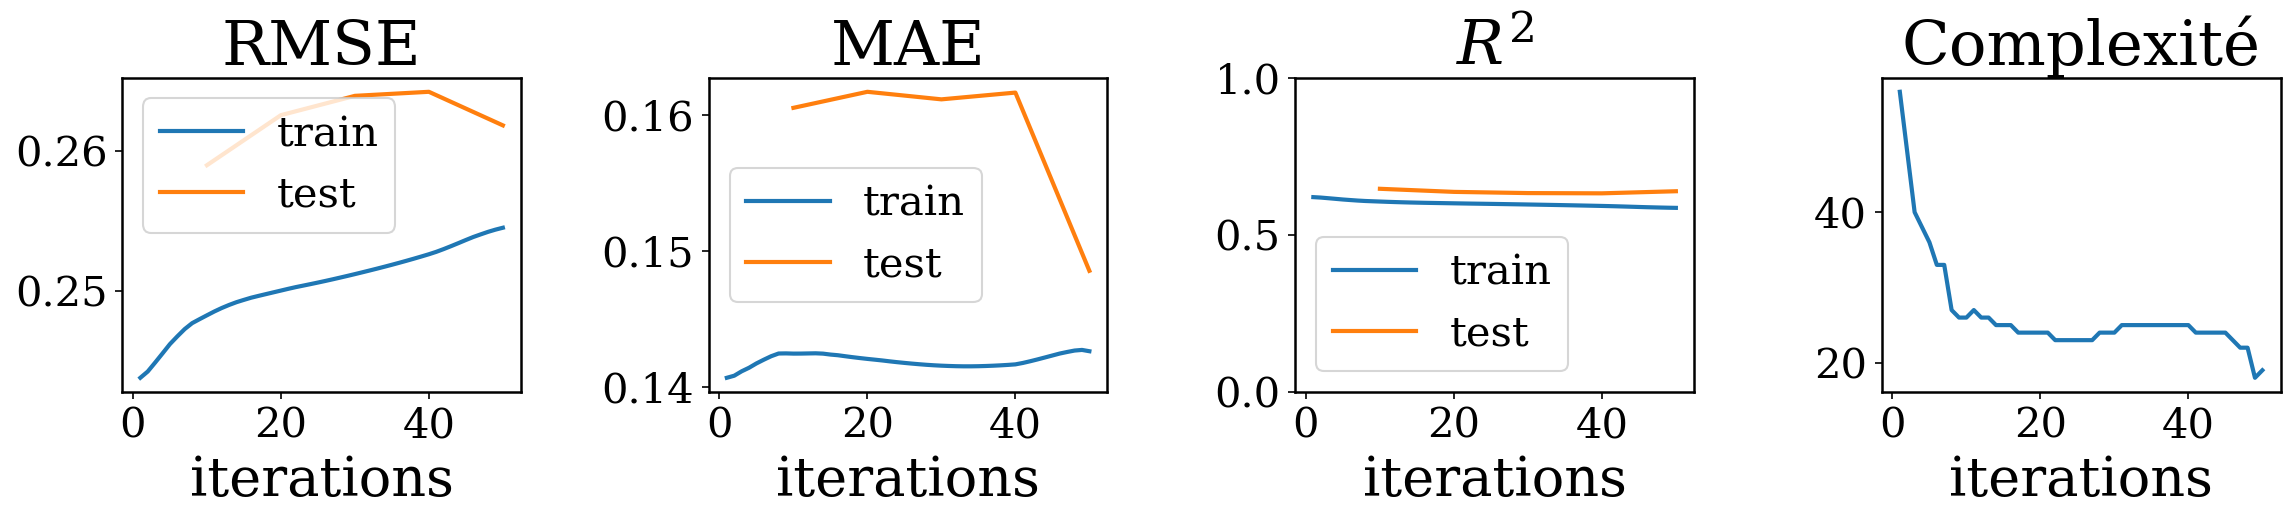

In [39]:
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

mae_train = opt_sindy.mae_history
mse_train = opt_sindy.mse_history
r2_train = opt_sindy.r2_history
compl_hist = np.count_nonzero(np.array(opt_sindy.history_), axis=(1, 2))[:-1]

#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters_complet = np.arange(1, n_iters+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(sindy_iters_complet, np.sqrt(mse_train), label='train')
ax0.plot(sindy_iters, np.sqrt(MSE_test), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')

ax1 = fig.add_subplot(gs[1])
ax1.plot(sindy_iters_complet, mae_train, label='train')
ax1.plot(sindy_iters, MAE_test, label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')

ax2 = fig.add_subplot(gs[2])
ax2.plot(sindy_iters_complet, r2_train, label='train')
ax2.plot(sindy_iters, R2_test, label='test')
# ax2.plot(70 * np.log(np.array(opt_sindy.mse_history)) + 2 * compl_hist) 
# ax2.plot(iters, compl, label='complexity')
# ax2.plot(iters, BIC_train, label='Btrain')
# ax2.plot(iters, BIC_test, label='Btest')
ax2.set_title(r'$R^2$')
ax2.set_ylim(0,1)
ax2.legend()
ax2.set_xlabel('iterations')

ax3 = fig.add_subplot(gs[3])
# ax3.plot(iters, AIC_train, label='train')
# ax3.plot(iters, AIC_test, label='test')
ax3.plot(sindy_iters_complet, compl_hist, label='complexity')
# ax2.plot(iters, BIC_train, label='Btrain')
# ax2.plot(iters, BIC_test, label='Btest')
ax3.set_title(r'Complexité')
#ax3.legend()
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




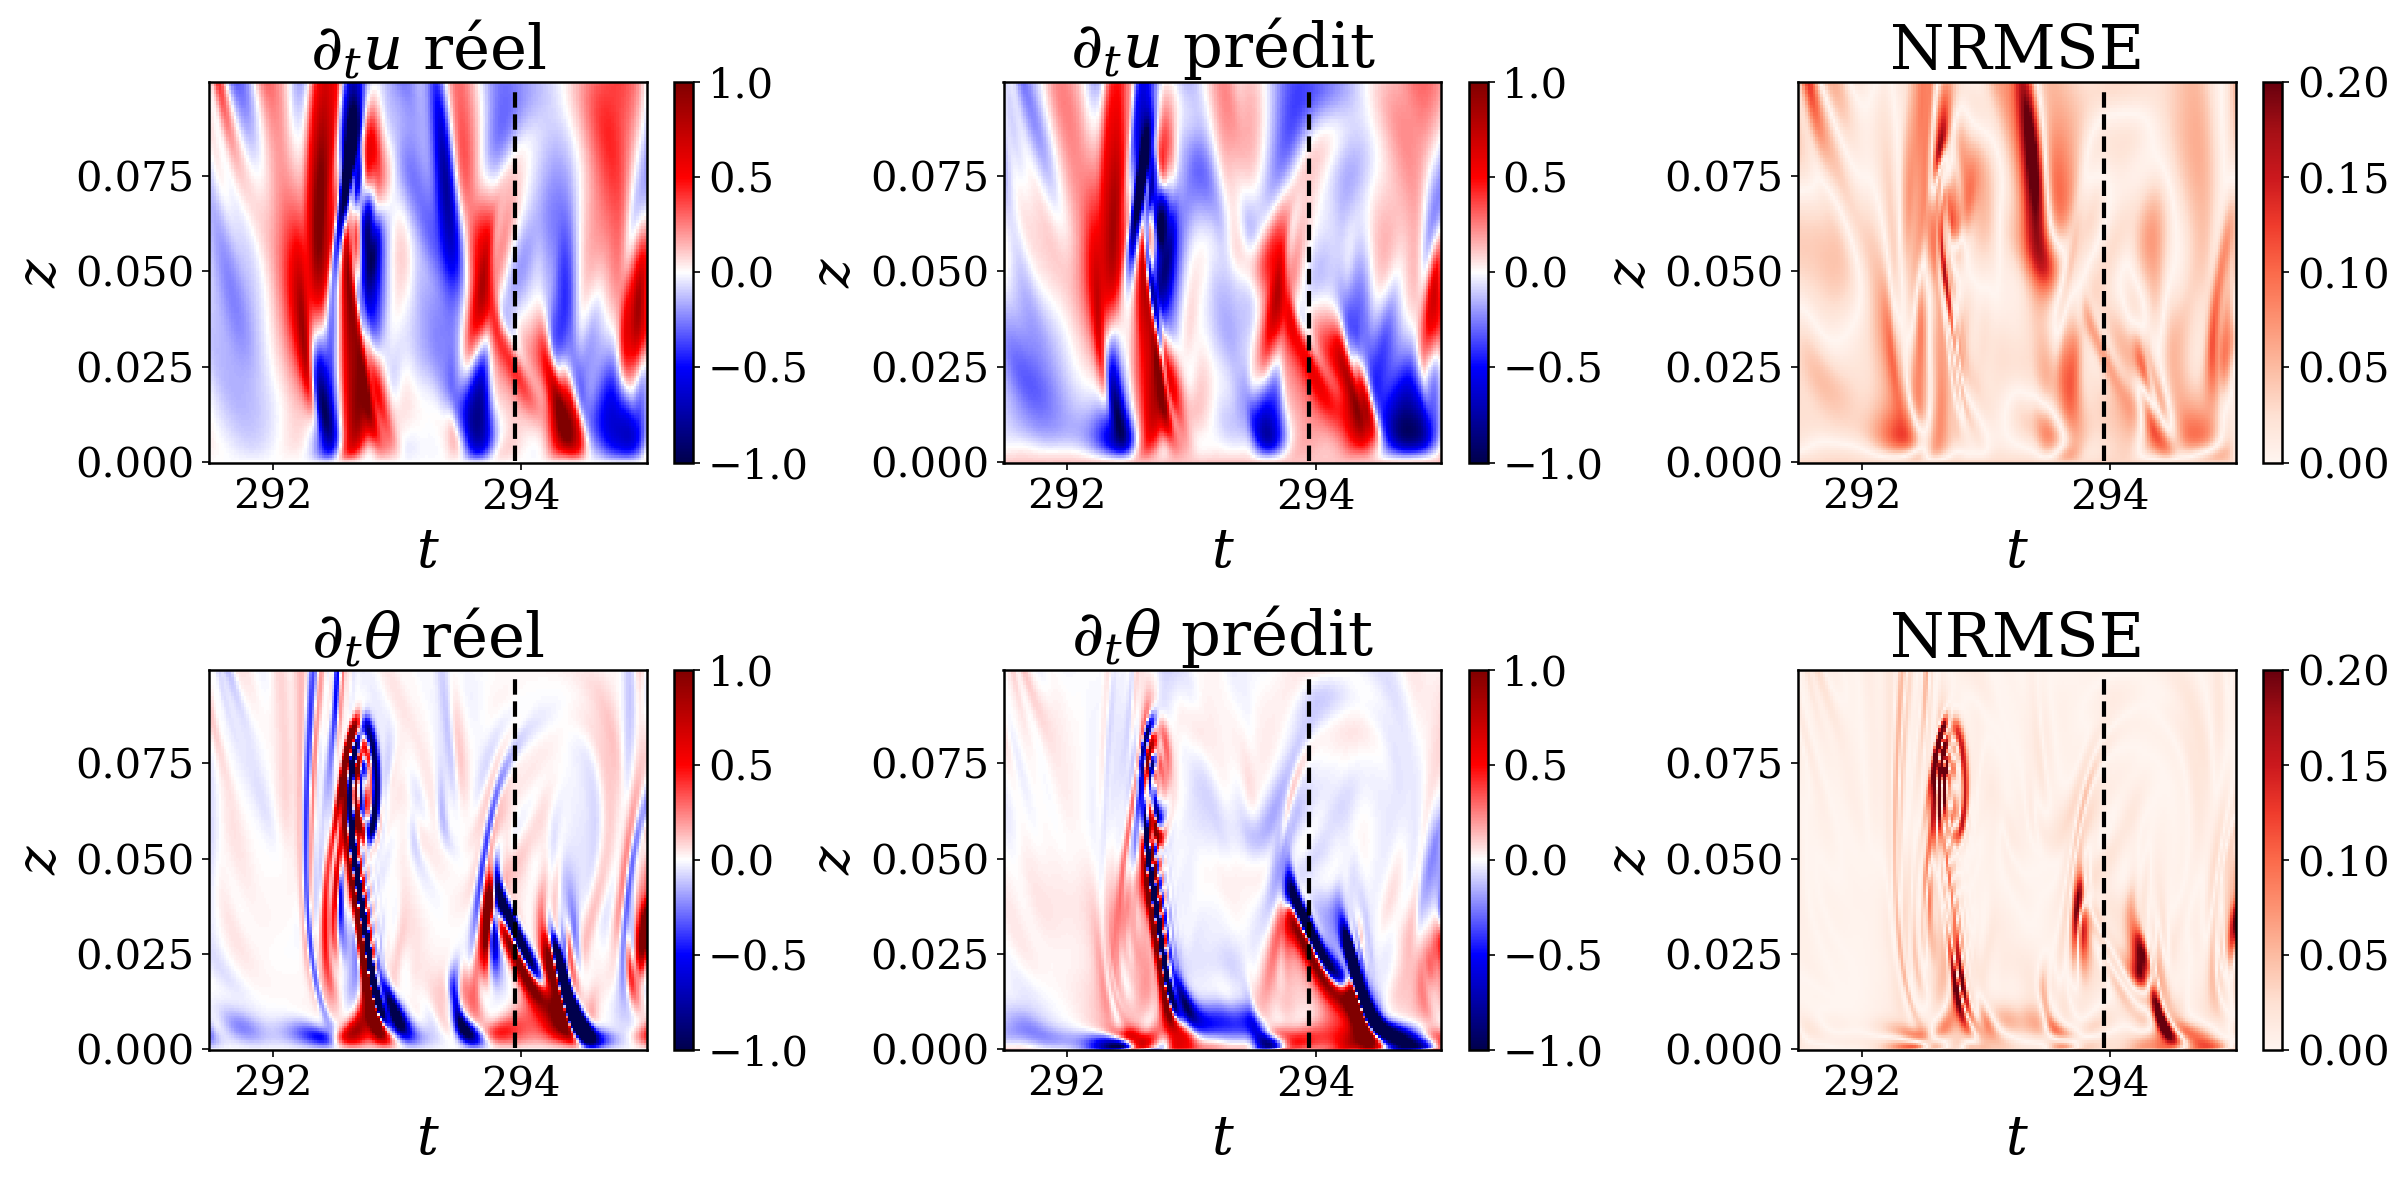

In [40]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.2)
norm = mcolors.TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
pred_sindy = model_sindy.predict(X)  


im1 = ax1.pcolor(t, (z), y[:,:,0], cmap='seismic', norm=norm)
ax1.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_t u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,:,0], cmap='seismic', norm=norm)
ax2.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_t u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), np.sqrt((y[:,:,0]-pred_sindy[:,:,0])**2)/(y[:,:,0].max() - y[:,:,0].min()), cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y[:,:,1], cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_t \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,:,1], cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_t \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), np.sqrt((y[:,:,1]-pred_sindy[:,:,1])**2)/(y[:,:,1].max() - y[:,:,1].min()), cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
fig.show()


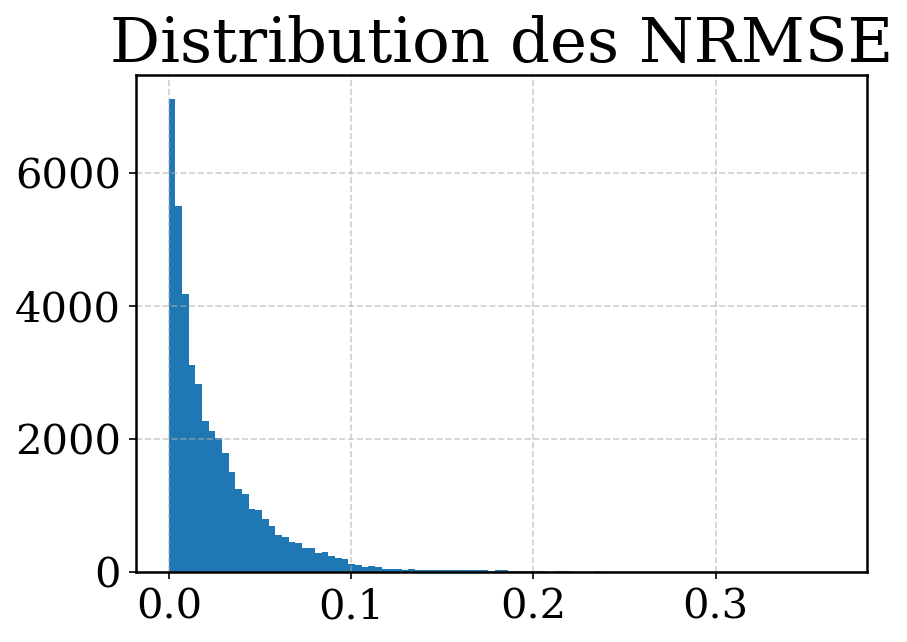

In [41]:
pred_sindy = model_sindy.predict(X)
c=0

NRMSE = np.sqrt((y[:,:,:]-pred_sindy[:,:,:])**2)/(y[:,:,:].max(axis=(0,1)) - y[:,:,:].min(axis=(0,1)))
plt.hist(NRMSE.flatten(), bins=100)
plt.grid(True)
plt.title("Distribution des NRMSE")
plt.tight_layout()
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_sindy.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_sindy.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()


### Weak-PDE SINDy

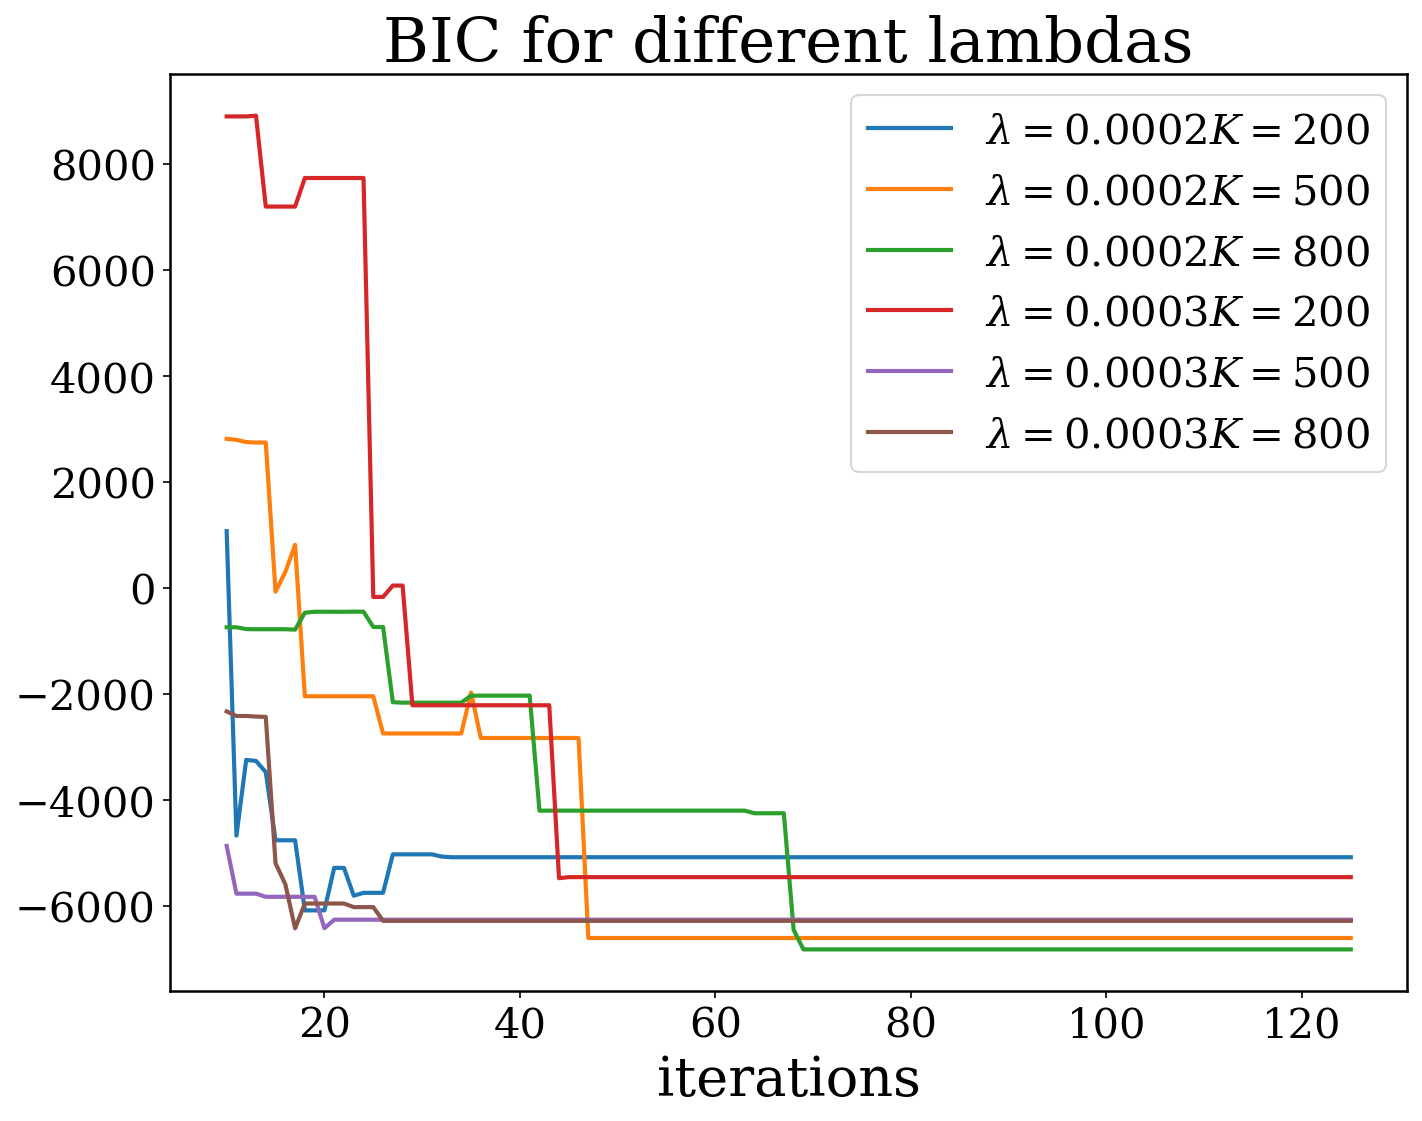

In [17]:
# choix de lambda
lamb_list = [.0002, .0003]
nu_list = [10] 
K_list = [200, 500, 800]

plt.figure(figsize=(10, 8))
ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)

for lamb in lamb_list : 
    for K in K_list : 

        # SINDy avec WeakPDELibrary
        # création des librairies de fonctions
        library_functions = [lambda x: x]
        library_function_names = [lambda x: x]


        # pour WeakSINDy
        weak_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                derivative_order=2,
                                spatiotemporal_grid=ZT[:,train_id,:], # grille spatio-temporelle (z, t)
                                include_bias=True,
                                include_interaction=True,
                                is_uniform=False, 
                                K=K) # K : nombre de sous-domaines

        # print("Nombre de fonctions :",weak_lib.fit(X).n_output_features_)
        # print("Librairie de fonctons :\n",weak_lib.fit(X).get_feature_names())

        # pour SINDy 
        pde_lib = ps.PDELibrary(library_functions=library_functions, 
                                function_names=library_function_names, 
                                derivative_order=2, 
                                spatial_grid=z, # grille spatiale (z)
                                include_bias=True,
                                include_interaction=True,
                                is_uniform=False)

        # permet de faire des predict sur toutes les données avec WeakSINDy
        X_transf = pde_lib.fit_transform(X)
        X_train_transf = pde_lib.fit_transform(X_train)
        X_test_transf = pde_lib.transform(X_test)

        
        #ax2.plot(iters, R2_test)
        MAE_train, MAE_test = [], []
        R2_train, R2_test = [], []
        MSE_train, MSE_test = [], []
        MAPE_train, MAPE_test = [], []
        compl = []
        n_iters = 125

        opt_weak = ps.SR3(threshold=lamb, thresholder='l1', nu=10, normalize_columns=True, max_iter=n_iters)
        model_weak = ps.SINDy(feature_library=weak_lib, optimizer=opt_weak, feature_names=['u', 'w', 'T'])

        iters = range(10, n_iters+1, 1)
        for i in iters:
            model_weak.optimizer.max_iter = i
            model_weak.fit(X_train, t=t_train, quiet=True)

            # prediction
            coeff_weak = model_weak.coefficients()
            pred_train = (X_train_transf @ coeff_weak.T   )[:,:,[0,2]]
            pred_test = (X_test_transf @ coeff_weak.T)[:,:,[0,2]]


            zmin=0 # /!\ choix du premier z proche paroi // on voit que moins bon en proche paroi : assimilé à du bruit ?

            # metric train/test
            MAE_train.append(np.mean(np.abs(y_train - pred_train)))
            MAE_test.append(np.mean(np.abs(y_test - pred_test))    )
            MSE_train.append(np.mean((y_train - pred_train)**2))
            MSE_test.append(np.mean((y_test - pred_test)**2))
            R2_train.append(1 - MSE_train[-1] / np.mean((y_train - y_train.mean(axis=(0, 1)))**2))
            R2_test.append(1 - MSE_test[-1] / np.mean((y_test - y_test.mean(axis=(0, 1)))**2))
            compl.append(np.count_nonzero(model_weak.coefficients()[[0, 2]]))

        n_train = len(t_train)* len(z)
        n_test = len(t_test)* len(z)
        AIC_test = n_test * np.log(MSE_test) + 2* np.array(compl)
        AIC_train = n_train * np.log(MSE_train) + 2* np.array(compl)
        BIC_test = n_test * np.log(MSE_test) + np.log(n_test)* np.array(compl)
        BIC_train = n_train * np.log(MSE_train) + np.log(n_train)* np.array(compl)

        ax1.plot(iters, BIC_test, label=r'$\lambda=$'+f"{lamb}"+r"$ K=$"+f'{K}')



ax1.legend()
plt.title('BIC for different lambdas')
ax1.set_xlabel('iterations')
plt.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_bicK_weak.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_bicK_weak.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()

In [42]:

### Pour SR3

# SINDy avec WeakPDELibrary
# création des librairies de fonctions
library_functions = [lambda x: x]
library_function_names = [lambda x: x]


# pour WeakSINDy
weak_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2,
                        spatiotemporal_grid=ZT[:,train_id,:], # grille spatio-temporelle (z, t)
                        include_bias=True,
                        include_interaction=True,
                        is_uniform=False, 
                        K=500) # K : nombre de sous-domaines

np.random.seed(1501)
# pour SINDy 
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, 
                        spatial_grid=z, # grille spatiale (z)
                        include_bias=True,
                        include_interaction=True,
                        is_uniform=False)

# permet de faire des predict sur toutes les données avec WeakSINDy
X_transf = pde_lib.fit_transform(X)
X_train_transf = pde_lib.fit_transform(X_train)
X_test_transf = pde_lib.transform(X_test)

MAE_train, MAE_test = [], []
R2_train, R2_test = [], []
MSE_train, MSE_test = [], []
MAPE_train, MAPE_test = [], []
compl = []
n_iters = 100

opt_weak = ps.SR3(threshold=0.0002, thresholder='l1', nu=10, normalize_columns=True, max_iter=n_iters, tol=1e-30)
model_weak = ps.SINDy(feature_library=weak_lib, optimizer=opt_weak, feature_names=['u', 'w', 'T'])

weak_iters_complet = range(1, n_iters+1)
weak_iters = range(10, n_iters+1, 10)
for i in weak_iters:
    model_weak.optimizer.max_iter = i
    model_weak.fit(X_train, t=t_train, quiet=True)

    # prediction
    coeff_weak = model_weak.coefficients()
    pred_train = (X_train_transf @ coeff_weak.T   )[:,:,[0,2]]
    pred_test = (X_test_transf @ coeff_weak.T)[:,:,[0,2]]


    zmin=0 # /!\ choix du premier z proche paroi // on voit que moins bon en proche paroi : assimilé à du bruit ?

    # metric train/test
    MAE_train.append(np.mean(np.abs(y_train - pred_train)))
    MAE_test.append(np.mean(np.abs(y_test - pred_test))    )
    MSE_train.append(np.mean((y_train - pred_train)**2))
    MSE_test.append(np.mean((y_test - pred_test)**2))
    R2_train.append(1 - MSE_train[-1] / np.mean((y_train - y_train.mean(axis=(0, 1)))**2))
    R2_test.append(1 - MSE_test[-1] / np.mean((y_test - y_test.mean(axis=(0, 1)))**2))
    compl.append(np.count_nonzero(model_weak.coefficients()[[0, 2]]))

mae_train = opt_weak.mae_history
mse_train = opt_weak.mse_history
r2_train = opt_weak.r2_history
compl_hist = np.count_nonzero(np.array(opt_weak.history_)[:,[0,2],:], axis=(1, 2))[:-1]
weak_mse_train = MSE_train
weak_mse_test = MSE_test
weak_mae_train = MAE_train
weak_mae_test = MAE_test
weak_r2_train = R2_train
weak_r2_test = R2_test
weak_compl = compl_hist

print(r"Modèle SINDy-Weak avec SR3:")
print("     Nombre de coefficients d'apprentissage :", nb_coeff)
print("     Complexité du modèle :", compl[-1])
print("     R2 score | training : ", R2_train[-1], "| testing : ", R2_test[-1]) # r2 
print("     MSE score | training : ", MSE_train[-1], "| testing : ", MSE_test[-1]) # r2 
print("     RMSE score | training : ", np.sqrt(MSE_train[-1]), "| testing : ", np.sqrt(MSE_test[-1])) # r2 
print("     MAE score | training : ", MAE_train[-1], "| testing : ", MAE_test[-1]) # mse
print('\n\n')
model_weak.print()


Modèle SINDy-Weak avec SR3:
     Nombre de coefficients d'apprentissage : (2, 28)
     Complexité du modèle : 11
     R2 score | training :  0.5067419519366985 | testing :  0.4867112282309827
     MSE score | training :  0.07712062198329556 | testing :  0.09732884554538392
     RMSE score | training :  0.2777059991849214 | testing :  0.3119757130697579
     MAE score | training :  0.16131182231334373 | testing :  0.18156801508006593



(u)' = 0.028 u_1 + -0.220 uu_1 + -0.107 uw_1 + 0.287 wu_1 + 0.203 wT_1
(w)' = -2.349 1 + -1.196 w + 5.089 T + -0.520 u_1 + 2.721 w_1 + 0.584 uu_1 + 1.002 uT_1 + -0.683 wu_1 + 1.167 ww_1 + -5.424 wT_1 + -0.849 Tu_1 + 1.128 Tw_1 + 0.287 TT_1 + 0.001 uu_11 + 0.002 uw_11 + -0.005 wu_11 + 0.012 ww_11 + -0.003 Tu_11 + 0.004 Tw_11 + 0.001 TT_11
(T)' = -0.003 wu_1 + 0.641 Tw_1 + 0.001 wT_11


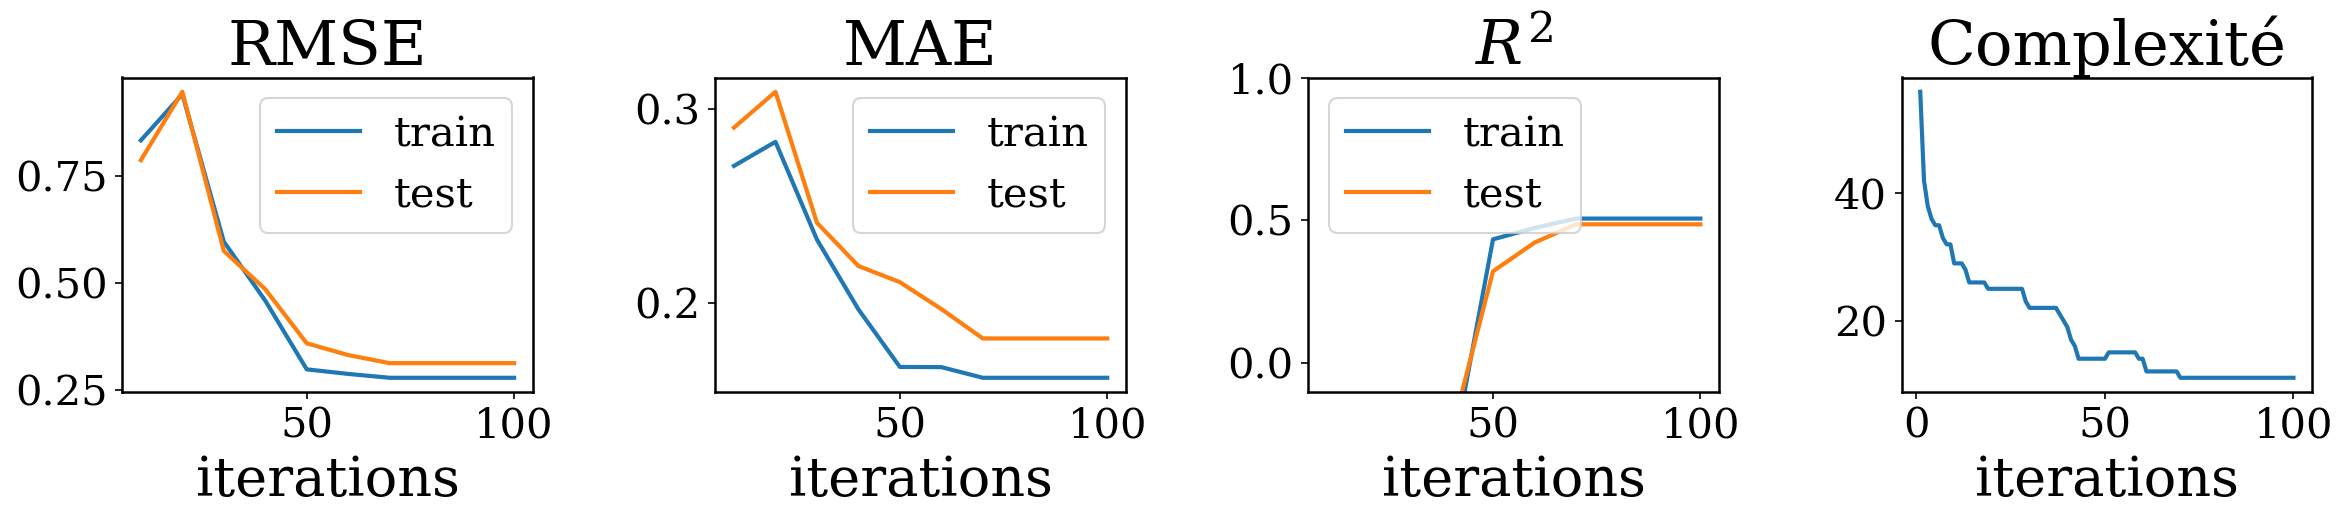

In [43]:
fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])



#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters_complet = np.arange(1, len(opt_weak.mae_history)+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(weak_iters, np.sqrt(MSE_train), label='train')
ax0.plot(weak_iters, np.sqrt(MSE_test), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')

ax1 = fig.add_subplot(gs[1])
ax1.plot(weak_iters, MAE_train, label='train')
ax1.plot(weak_iters, MAE_test, label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')

ax2 = fig.add_subplot(gs[2])
ax2.plot(weak_iters, R2_train, label='train')
ax2.plot(weak_iters, R2_test, label='test')
# ax2.plot(70 * np.log(np.array(opt_sindy.mse_history)) + 2 * compl_hist) 
# ax2.plot(iters, compl, label='complexity')
# ax2.plot(iters, BIC_train, label='Btrain')
# ax2.plot(iters, BIC_test, label='Btest')
ax2.set_title(r'$R^2$')
ax2.set_ylim(-.1, 1)
ax2.legend()
ax2.set_xlabel('iterations')

ax3 = fig.add_subplot(gs[3])
# ax3.plot(iters, AIC_train, label='train')
# ax3.plot(iters, AIC_test, label='test')
weak_compl = np.count_nonzero(np.array(opt_weak.history_)[:,[0,2],:], axis=(1, 2))[:-1]
ax3.plot(weak_iters_complet, weak_compl, label='complexity')
# ax2.plot(iters, BIC_train, label='Btrain')
# ax2.plot(iters, BIC_test, label='Btest')
ax3.set_title(r'Complexité')
#ax3.legend()
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_weak.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_weak.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




In [113]:
R2_train

[AxesArray(-0.85353605),
 AxesArray(-2.01094016),
 AxesArray(-2.2653245),
 AxesArray(-1.27470423),
 AxesArray(-2.14056093),
 AxesArray(-0.07166148),
 AxesArray(-0.07166148),
 AxesArray(-0.07166148),
 AxesArray(-0.07166148),
 AxesArray(-0.07166148)]

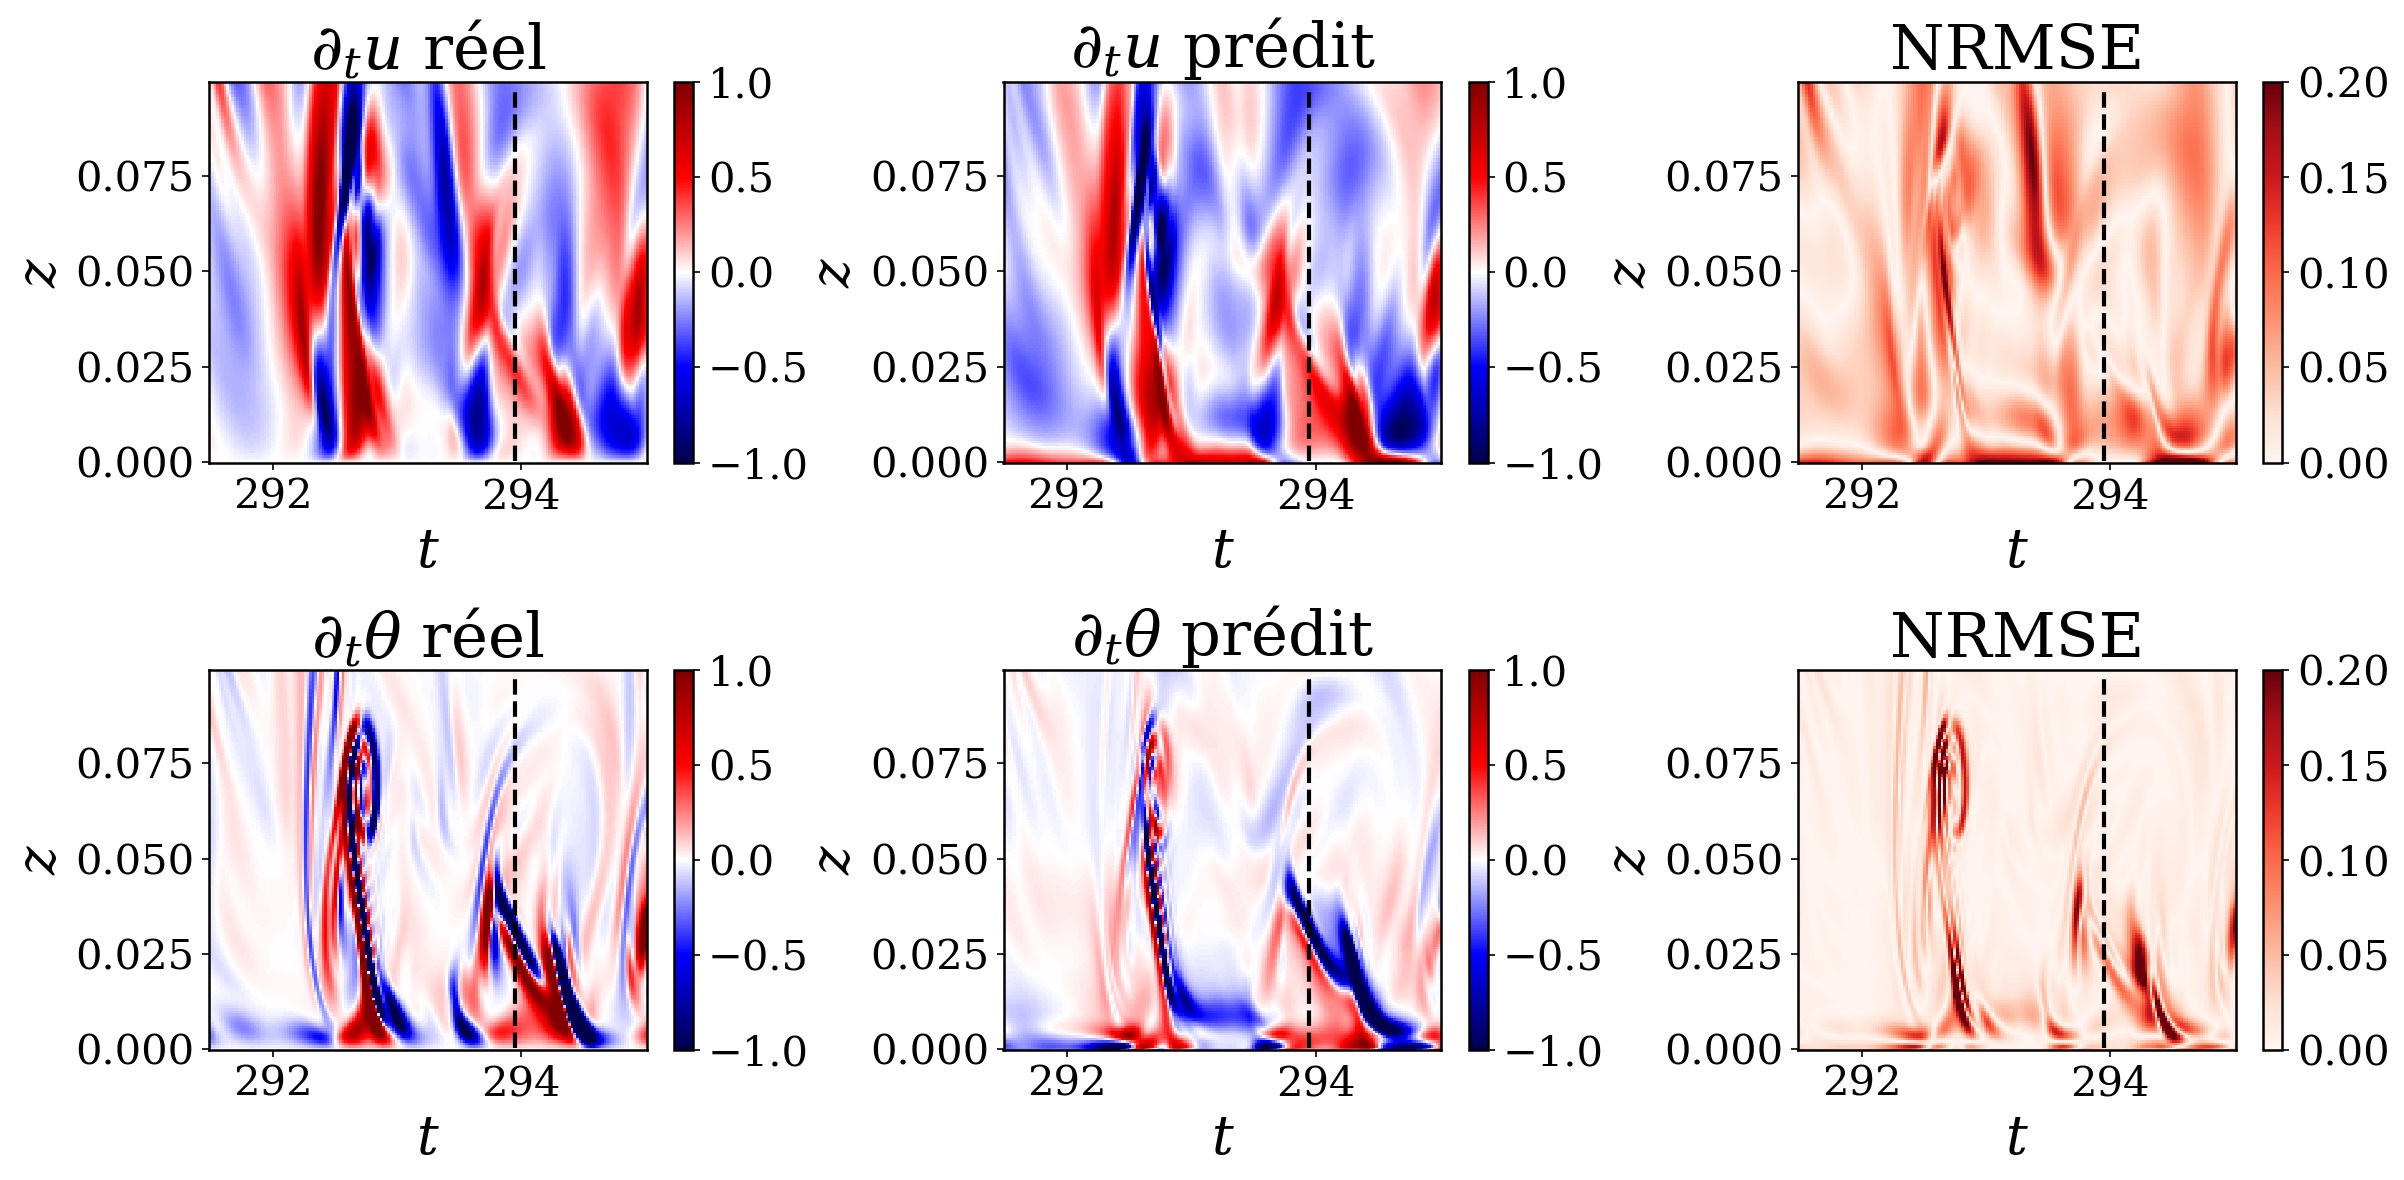

In [44]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.2)
norm = mcolors.TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
coeff_weak = model_weak.coefficients()
pred_sindy = (X_transf @ coeff_weak.T)[:,:,[0,2]]


im1 = ax1.pcolor(t, (z), y[:,:,0], cmap='seismic', norm=norm)
ax1.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_t u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,:,0], cmap='seismic', norm=norm)
ax2.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_t u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), np.sqrt((y[:,:,0]-pred_sindy[:,:,0])**2)/(y[:,:,0].max() - y[:,:,0].min()), cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y[:,:,1], cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_t \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,:,1], cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_t \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), np.sqrt((y[:,:,1]-pred_sindy[:,:,1])**2)/(y[:,:,1].max() - y[:,:,1].min()), cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_weak.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_weak.pdf', bbox_inches='tight', transparent=True, backend='pdf')
fig.show()


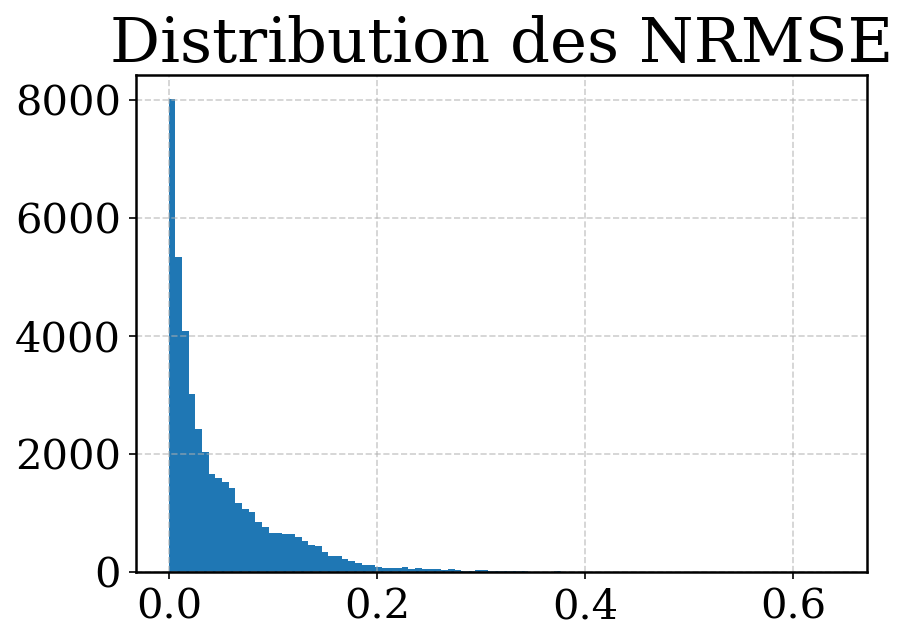

In [45]:
coeff_weak = model_weak.coefficients()
pred_sindy = (X_transf @ coeff_weak.T)[:,:,[0,2]]
c=0

NRMSE = np.sqrt((y[:,:,:]-pred_sindy[:,:,:])**2)/np.abs(y[:,:,:]).max(axis=(0,1))
plt.hist(NRMSE.flatten(), bins=100)

plt.title("Distribution des NRMSE")
plt.tight_layout()
plt.grid(True)
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_weak.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_weak.pdf', bbox_inches='tight', transparent=True, backend='pdf' )
plt.show()


### KAN

voir le fichier exploration_kan.ipynb, version améliorée de ça 


In [46]:
in_vars=['$u$', '$w$', r'$\theta$', 
        r'$\frac{\partial u}{\partial z}$', 
        r'$\frac{\partial w}{\partial z}$', 
        r'$\frac{\partial \theta}{\partial z}$', 
        r'$\frac{\partial^2 u}{\partial z^2}$', 
        r'$\frac{\partial^2 w}{\partial z^2}$', 
        r'$\frac{\partial^2 \theta}{\partial z^2}$', ]
out_vars=[r'$\frac{\partial u}{\partial t}$', 
        r'$\frac{\partial \theta}{\partial t}$']
len(in_vars)

9

In [47]:

model = kan.KAN(width=[data_kan['test_input'].shape[-1], [5, 0], 2], grid=3, k=3, seed=1501, sparse_init=False)
kan_compl = [9*5 + 5*2]
var_imp = []
steps_list = [0, 12, 0, 12]
losses = model.fit(
    data_kan, batch=-1, steps=steps_list[1], loss_fn=torch.nn.MSELoss(),
    update_grid = True, grid_update_num=3,
    lr = 5e-1, lamb=0.001, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )
#model.refine(6)
losses2 = model.fit(
    data_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e-2, lamb=0.0001, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )

model.prune()
losses3 = model.fit(
    data_kan, batch=-1, steps=steps_list[3], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=0.001, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )

losses_total = {}
for k in losses.keys():
    losses_total[k] = losses[k] + losses2[k] + losses3[k] #+ losses33[k] 
losses_total['r2_score_train'] = 1 - losses_total['mse_loss_train'] / np.mean( (data_kan['train_label']-data_kan['train_label'].mean()).numpy()**2 )
losses_total['r2_score_test'] = 1 - losses_total['mse_loss_test'] / np.mean( (data_kan['test_label']-data_kan['test_label'].mean()).numpy()**2 )


print(r"Modèle KAN pruned avec LBFGS:")
print("     Nombre de coefficients d'apprentissage :", kan_compl[0])
print("     Complexité du modèle :", kan_compl[-1])
print("     R2 score | training : ", losses_total['r2_score_train'][-1], "| testing : ", losses_total['r2_score_test'][-1]) # r2 
print("     MSE score | training : ", losses_total['mse_loss_train'][-1], "| testing : ", losses_total['mse_loss_test'][-1]) # r2
print("     RMSE score | training : ", np.sqrt(losses_total['mse_loss_train'][-1]), "| testing : ", np.sqrt(losses_total['mse_loss_test'][-1])) # r2    
print("     MAE score | training : ", losses_total['l1_loss_train'][-1], "| testing : ",losses_total['l1_loss_test'][-1]) # mse
print('\n\n')


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.86e-01 | test_loss: 2.74e-01 | reg: 1.26e+01 | : 100%|█| 12/12 [00:18<00:00,  1.57s/


saving model version 0.1


description: 0it [00:00, ?it/s]


saving model version 0.2
saving model version 0.3


| train_loss: 1.84e-01 | test_loss: 2.70e-01 | reg: 1.20e+01 | : 100%|█| 12/12 [00:21<00:00,  1.77s/

saving model version 0.3
Modèle KAN pruned avec LBFGS:
     Nombre de coefficients d'apprentissage : 55
     Complexité du modèle : 44
     R2 score | training :  0.7832986936828632 | testing :  0.6171433105838783
     MSE score | training :  0.033897824585437775 | testing :  0.07272159308195114
     RMSE score | training :  0.18411361868541332 | testing :  0.26966941443543635
     MAE score | training :  0.11365123838186264 | testing :  0.15006881952285767





In [118]:
model.edge_scores[0].size()

torch.Size([5, 9])

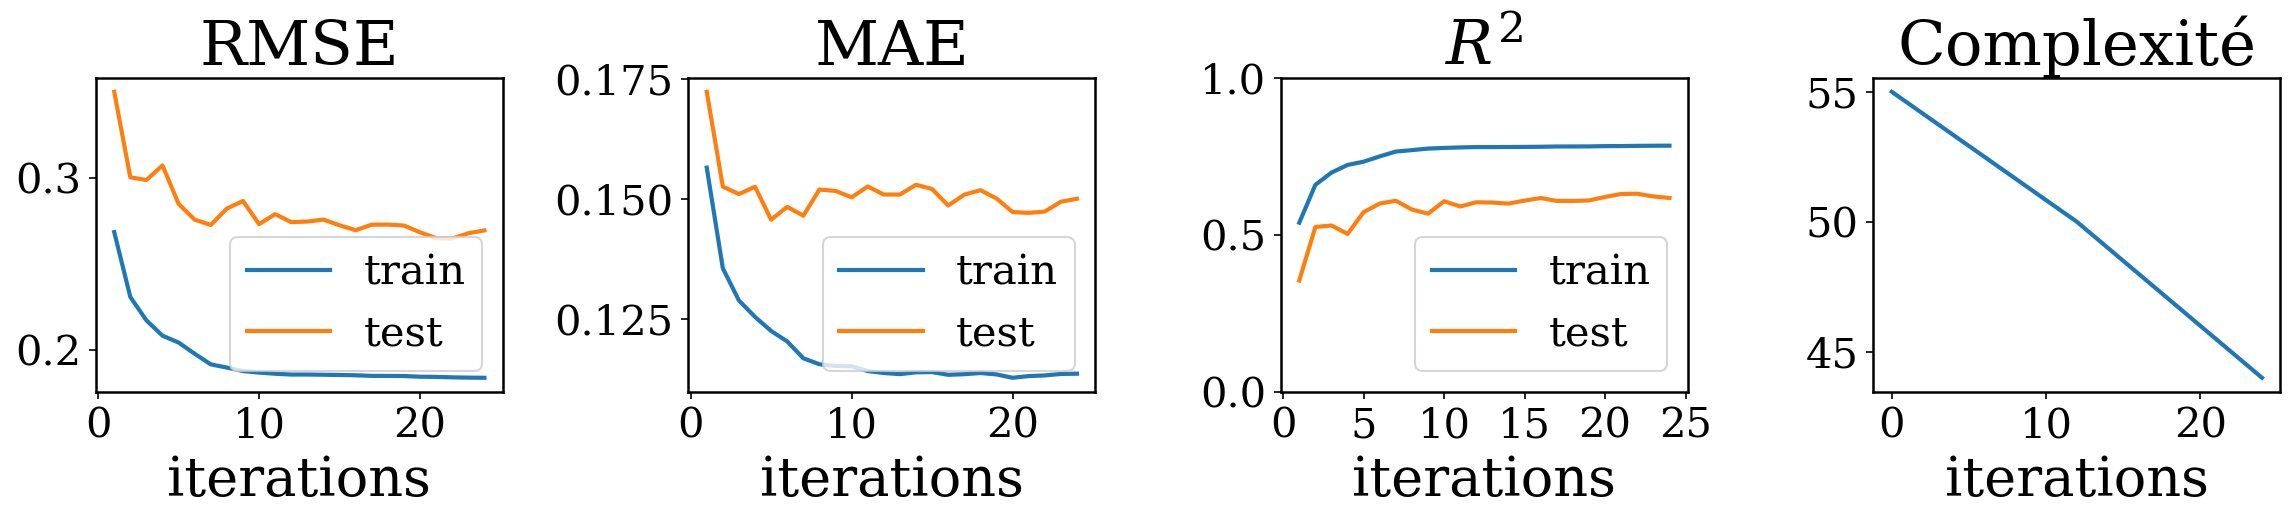

In [48]:

fig = plt.figure(figsize=(16, 4))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])




#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters = iters_complet = np.arange(1, np.sum(steps_list)+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(iters_complet, np.sqrt(losses_total['mse_loss_train']), label='train')
ax0.plot(iters, np.sqrt(losses_total['mse_loss_test']), label='test')
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')

ax1 = fig.add_subplot(gs[1])
ax1.plot(iters_complet, losses_total['l1_loss_train'], label='train')
ax1.plot(iters, losses_total['l1_loss_test'], label='test')
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')

ax2 = fig.add_subplot(gs[2])
ax2.plot(iters_complet, losses_total['r2_score_train'] , label='train')
ax2.plot(iters, losses_total['r2_score_test'] , label='test')
ax2.set_title(r'$R^2$')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_xlabel('iterations')
ax2.set_xticks([0, 5,10, 15, 20, 25])

ax3 = fig.add_subplot(gs[3])
ax3.plot(np.cumsum(steps_list), kan_compl, label='complexity')
ax3.set_title(r'Complexité')
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()




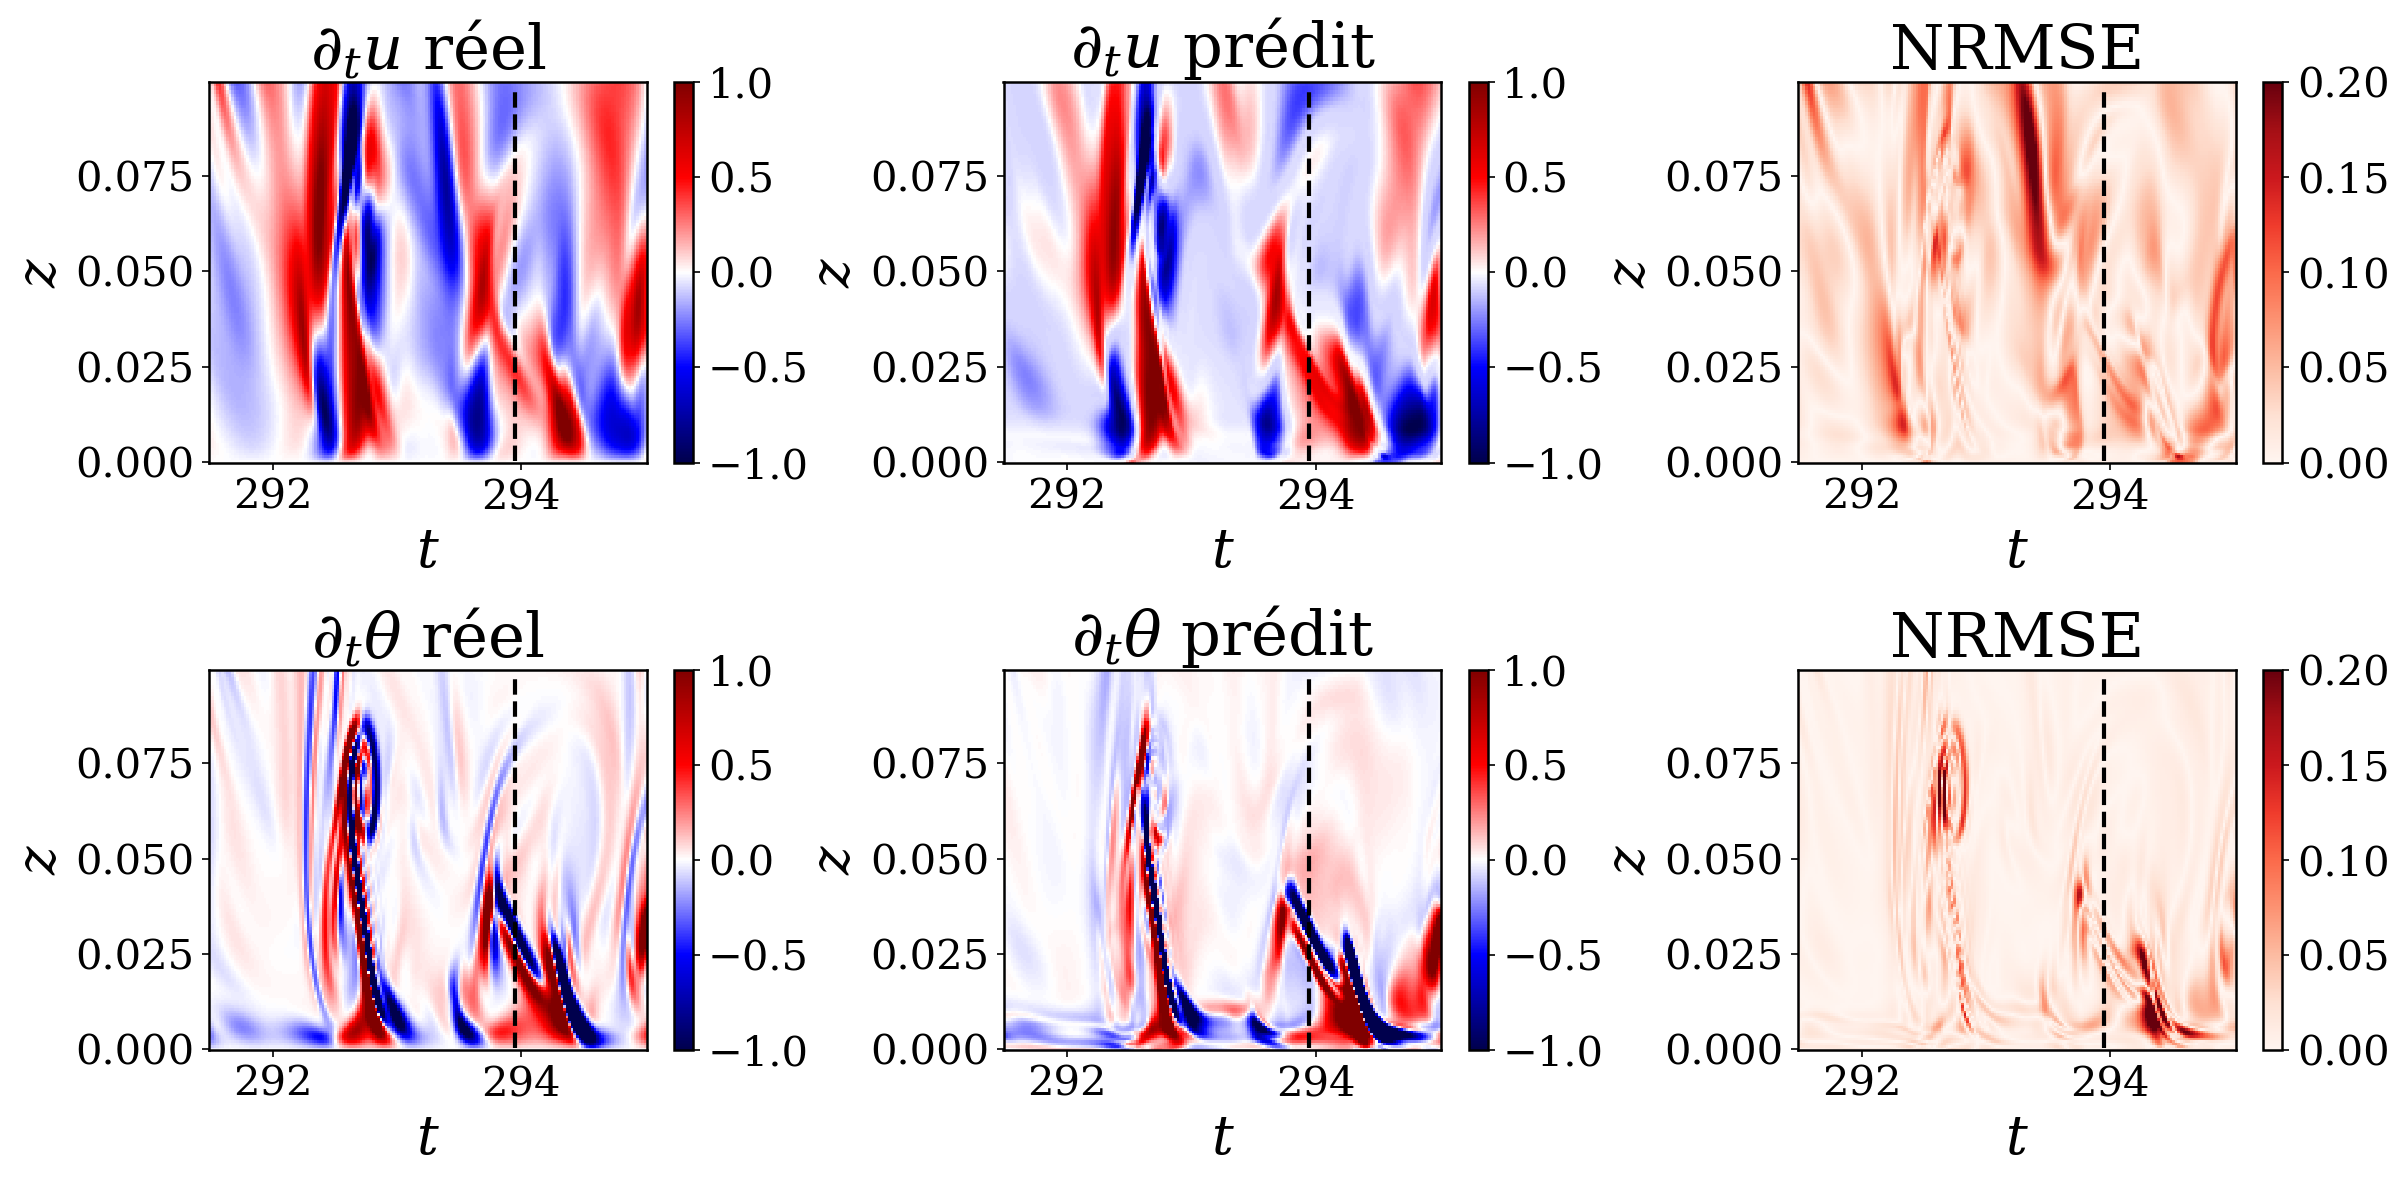

In [49]:
# SINDy

fig = plt.figure( figsize=(16,8))
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,3,4)
ax5 = plt.subplot(2,3,5)
ax6 = plt.subplot(2,3,6)

res_norm = mcolors.Normalize(vmin=0.0, vmax=0.2)
norm = mcolors.TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
# coeff_weak = model_weak.coefficients()
# pred_sindy = (X_transf @ coeff_weak.T)[:,:,[0,2]]

pred_train = model(data_kan['train_input']).detach().numpy().reshape(len(z), len(t_train), 2)
pred_test = model(data_kan['test_input']).detach().numpy().reshape(len(z), len(t_test), 2)
pred = np.concatenate((pred_train, pred_test), axis=1) 
pred_sindy = pred # unormalize(torch.from_numpy(pred), mean_y_kan, std_y_kan).detach().numpy()

# data_input = torch.concatenate([data_kan['train_input'], data_kan['test_input']], dim=0)
# pred_sindy = model(data_input).detach().numpy().reshape(len(z), len(t), 2)

im1 = ax1.pcolor(t, (z), y[:,:,0], cmap='seismic', norm=norm)
ax1.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im1, ax=ax1)
ax1.set_title(r"$\partial_t u$ réel")
ax1.set_ylabel('$z$')
ax1.set_xlabel('$t$')


im2 = ax2.pcolor(t, (z), pred_sindy[:,:,0], cmap='seismic', norm=norm)
ax2.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im2, ax=ax2)
ax2.set_title(r"$\partial_t u$ prédit")
ax2.set_ylabel('$z$')
ax2.set_xlabel('$t$')


im3 = ax3.pcolor(t, (z), np.sqrt((y[:,:,0]-pred_sindy[:,:,0])**2)/(y[:,:,0].max() - y[:,:,0].min()), cmap='Reds', norm=res_norm)
ax3.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im3, ax=ax3)
ax3.set_title(r"NRMSE")
ax3.set_ylabel('$z$')
ax3.set_xlabel('$t$')

im4 = ax4.pcolor(t, (z), y[:,:,1], cmap='seismic', norm=norm)
ax4.vlines(t[train_id[-1]], (z[1]), (z[-2]), ls='dashed', colors='k', linewidth=2)
plt.colorbar(im4, ax=ax4)
ax4.set_title(r"$\partial_t \theta$ réel")
ax4.set_ylabel('$z$')
ax4.set_xlabel('$t$')


im5 = ax5.pcolor(t, (z), pred_sindy[:,:,1], cmap='seismic', norm=norm)
ax5.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im5, ax=ax5)
ax5.set_title(r"$\partial_t \theta$ prédit")
ax5.set_ylabel('$z$')
ax5.set_xlabel('$t$')


im6 = ax6.pcolor(t, (z), np.sqrt((y[:,:,1]-pred_sindy[:,:,1])**2)/(y[:,:,1].max() - y[:,:,1].min()), cmap='Reds', norm=res_norm)
ax6.vlines(t[train_id[-1]], z[1], z[-2], ls='dashed', colors='k', linewidth=2)
plt.colorbar(im6, ax=ax6)
ax6.set_title(r"NRMSE")
ax6.set_ylabel('$z$')
ax6.set_xlabel('$t$')

fig.tight_layout(pad=0.5)
plt.savefig(f'FIGURES/pb{num_pb}_res_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_res_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
fig.show()


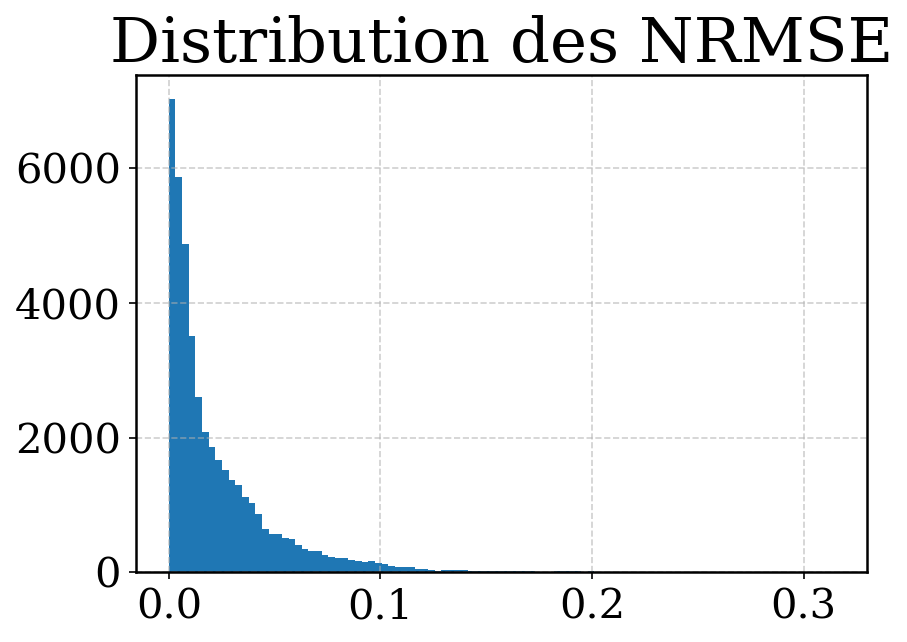

In [50]:


NRMSE = np.sqrt((y[:,:,:]-pred_sindy[:,:,:])**2)/(y[:,:,:].max(axis=(0, 1)) - y[:,:,:].min(axis=(0, 1)))
plt.hist(NRMSE.flatten(), bins=100)

plt.title("Distribution des NRMSE")
plt.grid(True)
plt.tight_layout()
plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_nrmse_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()


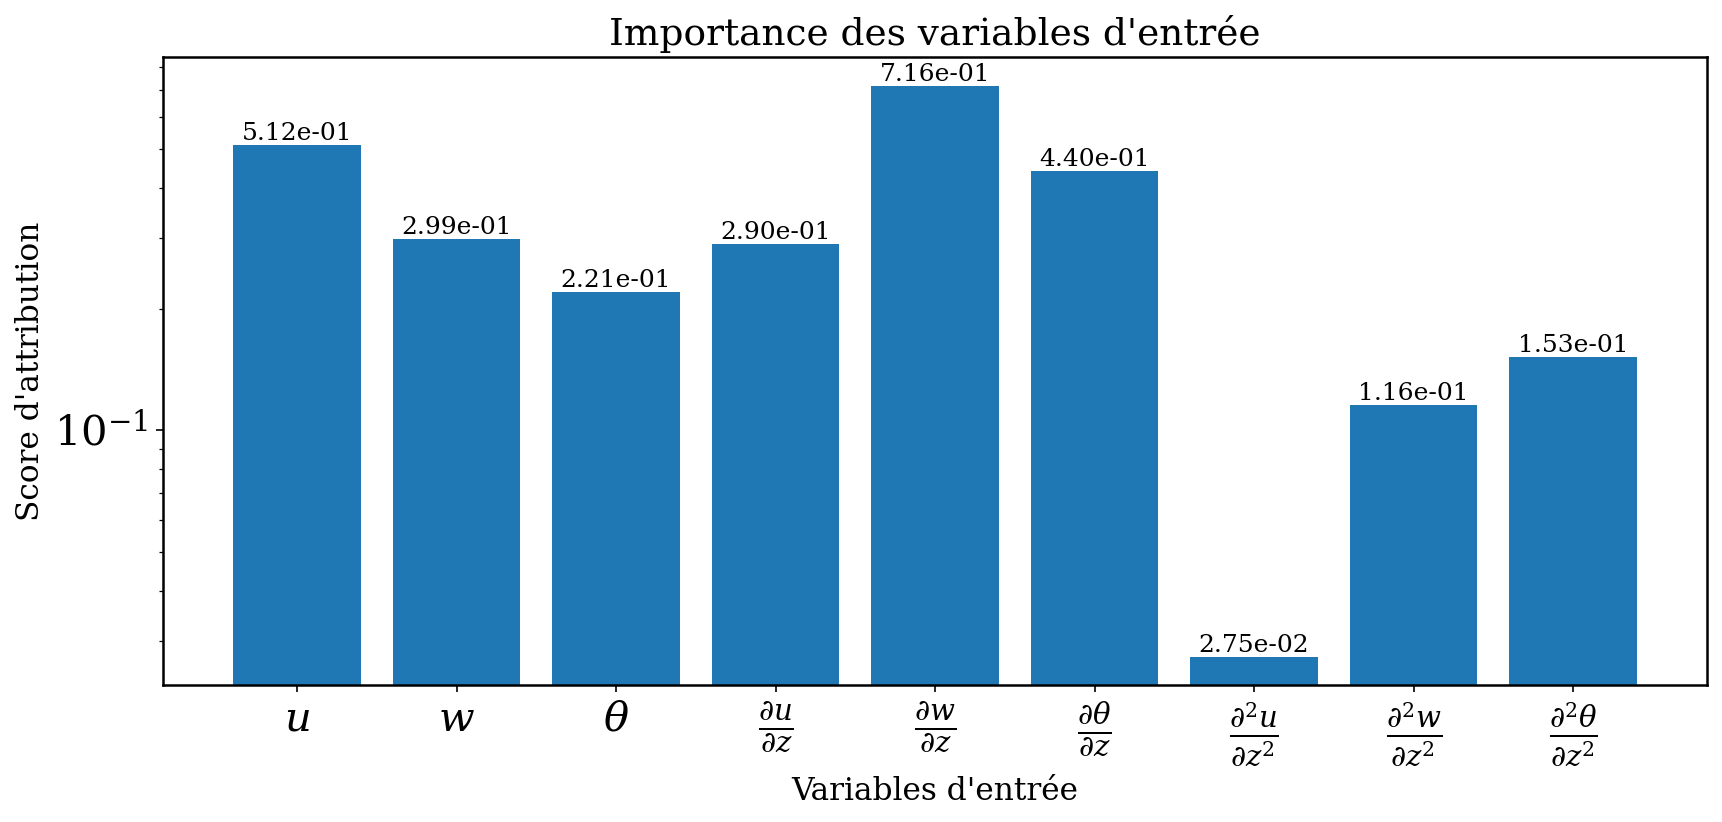

In [51]:
import numpy as np
import matplotlib.pyplot as plt

scores = model.feature_score.cpu().detach().numpy()
features = in_vars  # liste des noms des features

plt.figure(figsize=(12, 6))
bars = plt.bar(features, scores, color='tab:blue')

plt.yscale('log')
plt.xlabel('Variables d\'entrée', fontsize=15)
plt.ylabel('Score d\'attribution', fontsize=15)
plt.title("Importance des variables d'entrée", fontsize=18)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Optionnel : ajouter les valeurs au-dessus des barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.0,
             f'{height:.2e}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig(f'FIGURES/pb{num_pb}_varimp_kan.png', dpi=300, bbox_inches='tight', transparent=True)
plt.grid(False)
plt.savefig(f'FIGURES/pb{num_pb}_varimp_kan.pdf', bbox_inches='tight', transparent=True, backend='pdf')
plt.show()


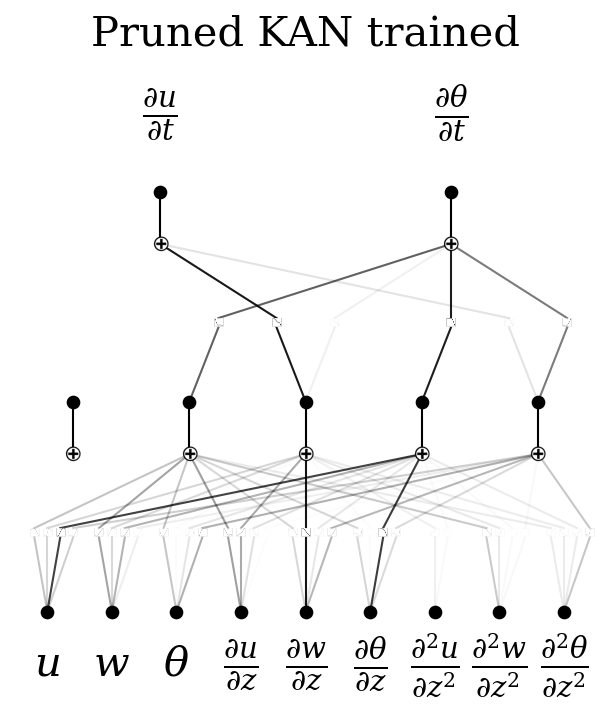

In [52]:
model.plot(in_vars=in_vars, out_vars=out_vars, title='Pruned KAN trained', folder= './FIGKAN/') # mettre juste 3 node addition 

In [124]:

model = kan.KAN(width=[data_kan['test_input'].shape[-1], [5, 0], 2], grid=3, k=3, seed=1501, sparse_init=False)
kan_compl = [9*5 + 5*2]
var_imp = []
steps_list = [0, 12, 0, 12, 76]
losses = model.fit(
    data_kan, batch=-1, steps=steps_list[1], loss_fn=torch.nn.MSELoss(),
    update_grid = True, grid_update_num=3,
    lr = 5e-1, lamb=0.001, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )
#model.refine(6)
losses2 = model.fit(
    data_kan, batch=-1, steps=steps_list[2], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=1,
    lr = 5e-2, lamb=0.0001, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )

model.prune()
losses3 = model.fit(
    data_kan, batch=-1, steps=steps_list[3], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=0.001, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )
model.prune()
losses4 = model.fit(
    data_kan, batch=-1, steps=steps_list[4], loss_fn=torch.nn.MSELoss(),
    update_grid = False, grid_update_num=3,
    lr = 5e-2, lamb=0.001, opt='LBFGS', 
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], log=1
)
var_imp.append(model.feature_score)
kan_compl.append( (model.edge_scores[0]>1e-5).sum().numpy() + (model.edge_scores[1]>1e-5).sum().numpy() )



losses_total = {}
for k in losses.keys():
    losses_total[k] = losses[k] + losses2[k] + losses3[k] + losses4[k] 
losses_total['r2_score_train'] = 1 - losses_total['mse_loss_train'] / np.mean( (data_kan['train_label']-data_kan['train_label'].mean()).numpy()**2 )
losses_total['r2_score_test'] = 1 - losses_total['mse_loss_test'] / np.mean( (data_kan['test_label']-data_kan['test_label'].mean()).numpy()**2 )


checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/12 [00:00<?, ?it/s]

| train_loss: 1.34e-01 | test_loss: 3.69e-01 | reg: 1.26e+01 | : 100%|█| 12/12 [00:11<00:00,  1.06it


saving model version 0.1


description: 0it [00:00, ?it/s]


saving model version 0.2
saving model version 0.3


| train_loss: 1.28e-01 | test_loss: 3.96e-01 | reg: 1.21e+01 | : 100%|█| 12/12 [00:13<00:00,  1.10s/


saving model version 0.3
saving model version 0.4


| train_loss: 1.19e-01 | test_loss: 5.33e-01 | reg: 1.12e+01 | : 100%|█| 76/76 [01:19<00:00,  1.05s/

saving model version 0.4


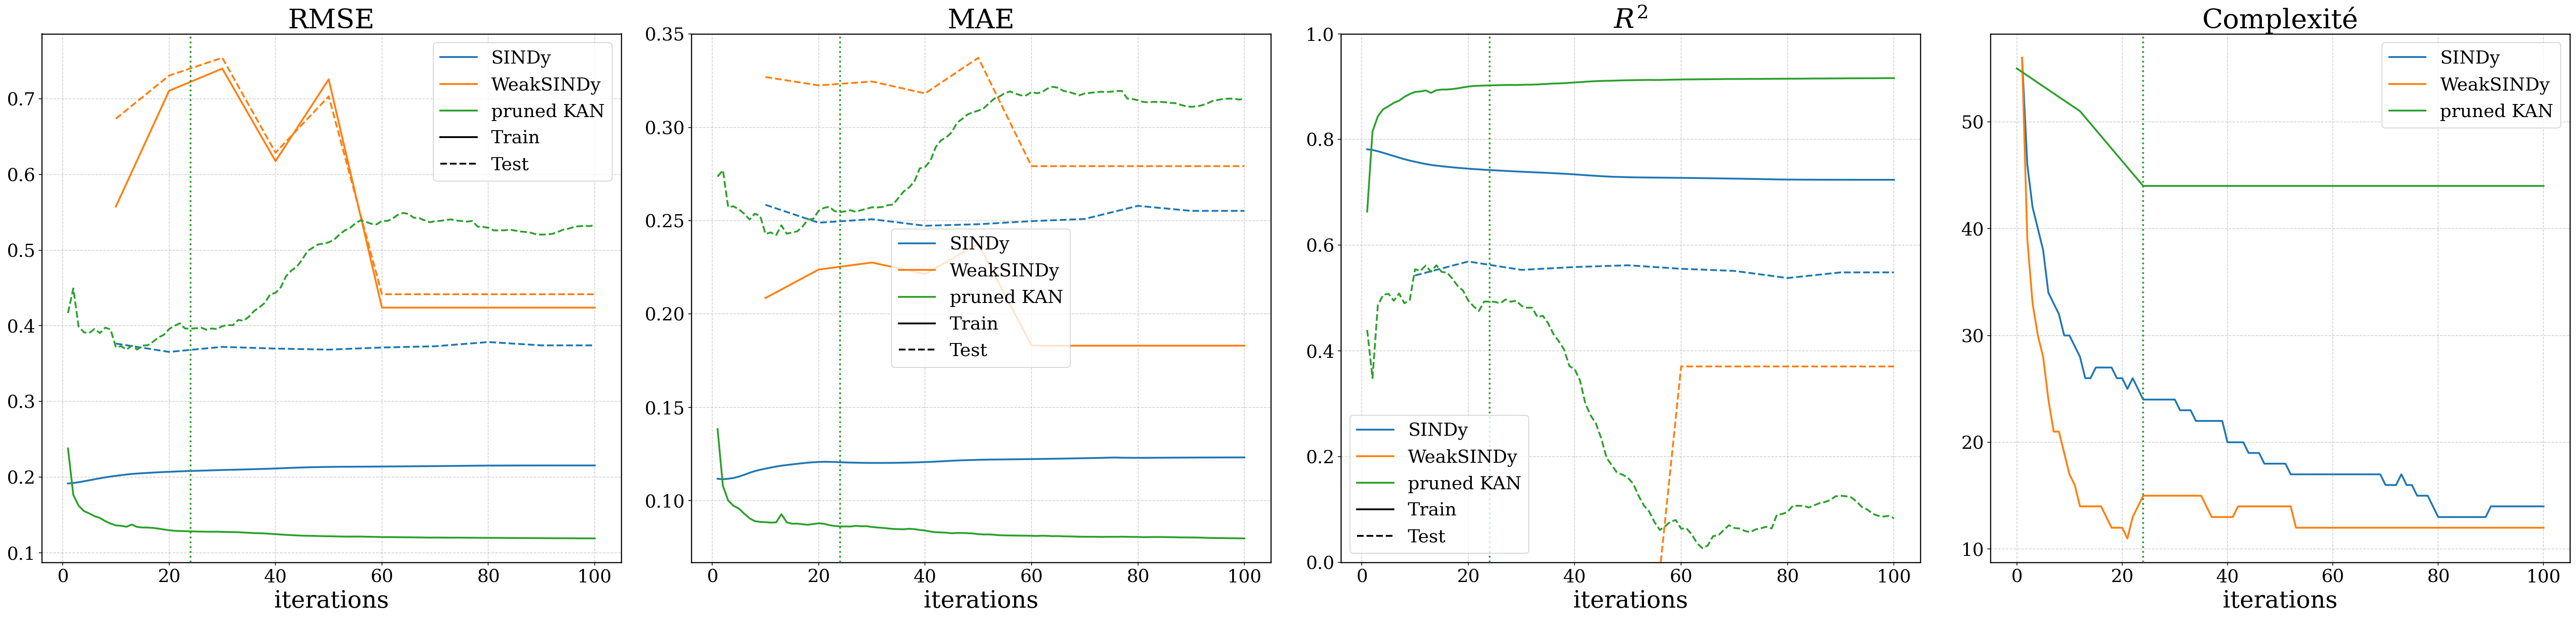

In [125]:

fig = plt.figure(figsize=(40, 10))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])
sindy_iter = range(1, len(sindy_mae_train)+1)

#fig.suptitle(r"Evaluation de PDE-SINDy avec SR3($R=\ell_1$, $\lambda=1$, $\nu=1$)")
iters = iters_complet = np.arange(1, np.sum(steps_list)+1)
ax0 = fig.add_subplot(gs[0])
ax0.plot(sindy_iters_complet, np.sqrt(sindy_mse_train), label='SINDy', color='C0', ls='-')
ax0.plot(sindy_iters, np.sqrt(sindy_mse_test), color='C0', ls='--')
ax0.plot(weak_iters, np.sqrt(weak_mse_train), label='WeakSINDy', color='C1', ls='-')
ax0.plot(weak_iters, np.sqrt(weak_mse_test), color='C1', ls='--')
ax0.plot(iters_complet, np.sqrt(losses_total['mse_loss_train']), label='pruned KAN', color='C2', ls='-')
ax0.plot(iters, np.sqrt(losses_total['mse_loss_test']), color='C2', ls='--')
ax0.plot([], [], 'k-', linewidth=2, label='Train')
ax0.plot([], [], 'k--', linewidth=2, label='Test')
ax0.axvline(
    x=np.sum(steps_list[:-1]),            # abscisse
    color='C2',      # troisième couleur de la palette Matplotlib default
    linestyle=':',
    linewidth=2,     # épaisseur (optionnel)
    zorder=5         # au‑dessus des autres tracés (optionnel)
)
ax0.legend()
ax0.set_title(r'RMSE')
ax0.set_xlabel('iterations')

ax1 = fig.add_subplot(gs[1])
# ax1.plot(iters_complet, losses_total['l1_loss_train'], label='train')
# ax1.plot(iters, losses_total['l1_loss_test'], label='test')

ax1.plot(sindy_iters_complet, (sindy_mae_train), label='SINDy', color='C0', ls='-')
ax1.plot(sindy_iters, (sindy_mae_test), color='C0', ls='--')
ax1.plot(weak_iters, (weak_mae_train), label='WeakSINDy', color='C1', ls='-')
ax1.plot(weak_iters, (weak_mae_test),  color='C1', ls='--')
ax1.plot(iters_complet, (losses_total['l1_loss_train']), label='pruned KAN', color='C2', ls='-')
ax1.plot(iters, (losses_total['l1_loss_test']), color='C2', ls='--')
ax1.plot([], [], 'k-', linewidth=2, label='Train')
ax1.plot([], [], 'k--', linewidth=2, label='Test')
ax1.axvline(
    x=np.sum(steps_list[:-1]),            # abscisse
    color='C2',      # troisième couleur de la palette Matplotlib default
    linestyle=':',
    linewidth=2,     # épaisseur (optionnel)
    zorder=5         # au‑dessus des autres tracés (optionnel)
)
ax1.legend()
ax1.set_title(r'MAE')
ax1.set_xlabel('iterations')

ax2 = fig.add_subplot(gs[2])
# ax2.plot(iters_complet, losses_total['r2_score_train'] , label='train')
# ax2.plot(iters, losses_total['r2_score_test'] , label='test')

ax2.plot(sindy_iters_complet, sindy_r2_train, label='SINDy', color='C0', ls='-')
ax2.plot(sindy_iters, sindy_r2_test, color='C0', ls='--')
ax2.plot(weak_iters, weak_r2_train, label='WeakSINDy', color='C1', ls='-')
ax2.plot(weak_iters, weak_r2_test, color='C1', ls='--')
ax2.plot(iters_complet, losses_total['r2_score_train'], label='pruned KAN', color='C2', ls='-')
ax2.plot(iters, losses_total['r2_score_test'], color='C2', ls='--')
ax2.plot([], [], 'k-', linewidth=2, label='Train')
ax2.plot([], [], 'k--', linewidth=2, label='Test')
ax2.axvline(
    x=np.sum(steps_list[:-1]),            # abscisse
    color='C2',      # troisième couleur de la palette Matplotlib default
    linestyle=':',
    linewidth=2,     # épaisseur (optionnel)
    zorder=5         # au‑dessus des autres tracés (optionnel)
)

ax2.set_title(r'$R^2$')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_xlabel('iterations')
#ax2.set_xticks([0, 5,10, 15, 20, 25])

ax3 = fig.add_subplot(gs[3])
ax3.plot(sindy_iters_complet, sindy_compl, label='SINDy')
ax3.plot(weak_iters_complet, weak_compl, label='WeakSINDy')
ax3.plot(np.cumsum(steps_list), kan_compl, label='pruned KAN')
ax3.axvline(
    x=np.sum(steps_list[:-1]),            # abscisse
    color='C2',      # troisième couleur de la palette Matplotlib default
    linestyle=':',
    linewidth=2,     # épaisseur (optionnel)
    zorder=5         # au‑dessus des autres tracés (optionnel)
)
ax3.legend()
ax3.set_title(r'Complexité')
ax3.set_xlabel('iterations')

fig.tight_layout()

plt.savefig(f'FIGURES/pb{num_pb}_metrics_convergence.png', dpi=300, bbox_inches='tight', transparent=True)

plt.savefig(f'FIGURES/pb{num_pb}_metrics_convergence.pdf', bbox_inches='tight', transparent=True)
plt.show()


